# Reset and Readout of Qubit

### Import

In [ ]:
#!pip install c3-toolset
#!pip install matplotlib
#!pip install plotly
#!pip install numpy
#!pip install --upgrade nbformat

In [1]:
import os
from re import I
import numpy as np
import copy
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from c3.c3objs import Quantity as Qty
from c3.parametermap import ParameterMap as PMap
from c3.experiment import Experiment as Exp
from c3.model import Model as Mdl
from c3.generator.generator import Generator as Gnr

# Building blocks
import c3.generator.devices as devices
import c3.signal.gates as gates
import c3.libraries.chip as chip
import c3.signal.pulse as pulse
import c3.libraries.tasks as tasks

# Libs and helpers
import c3.libraries.algorithms as algorithms
import c3.libraries.hamiltonians as hamiltonians
import c3.libraries.fidelities as fidelities
import c3.libraries.envelopes as envelopes
import c3.utils.qt_utils as qt_utils
import c3.utils.tf_utils as tf_utils
from c3.optimizers.optimalcontrol import OptimalControl

import plotly.graph_objects as go
from plotting import *
from utilities_functions import *

import scipy as sp

2022-05-19 09:51:41.629875: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-19 09:51:41.629897: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Define Qubit and resonator

Qubit

In [2]:
qubit_levels = 3
qubit_frequency = 7.86e9
qubit_anharm = -264e6
qubit_t1 = 27e-6
qubit_t2star = 39e-6
qubit_temp = 50e-3

qubit = chip.Qubit(
    name="Q",
    desc="Qubit",
    freq=Qty(value=qubit_frequency,min_val=1e9 ,max_val=8e9 ,unit='Hz 2pi'),
    anhar=Qty(value=qubit_anharm,min_val=-380e6 ,max_val=-120e6 ,unit='Hz 2pi'),
    hilbert_dim=qubit_levels,
    t1=Qty(value=qubit_t1,min_val=1e-6,max_val=90e-6,unit='s'),
    t2star=Qty(value=qubit_t2star,min_val=10e-6,max_val=90e-3,unit='s'),
    temp=Qty(value=qubit_temp,min_val=0.0,max_val=0.12,unit='K')
)

2022-05-18 08:23:54.068582: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-18 08:23:54.068638: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-18 08:23:54.068665: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ashutosh): /proc/driver/nvidia/version does not exist
2022-05-18 08:23:54.068969: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Resonator

In [3]:
resonator_levels = 3
resonator_frequency = 6.02e9
resonator_t1 = 27e-6
resonator_t2star = 39e-6
resonator_temp = 50e-3

parameters_resonator = {
    "freq": Qty(value=resonator_frequency,min_val=0e9 ,max_val=8e9 ,unit='Hz 2pi'),
    "t1": Qty(value=resonator_t1,min_val=1e-6,max_val=90e-6,unit='s'),
    "t2star": Qty(value=resonator_t2star,min_val=10e-6,max_val=90e-3,unit='s'),
    "temp": Qty(value=resonator_temp,min_val=0.0,max_val=0.12,unit='K')
}

resonator = chip.Resonator(
    name="R",
    desc="Resonator",
    hilbert_dim=resonator_levels,
    params=parameters_resonator
)

Coupling

In [4]:
coupling_strength = 130e6
qr_coupling = chip.Coupling(
    name="Q-R",
    desc="coupling",
    comment="Coupling qubit and resonator",
    connected=["Q", "R"],
    strength=Qty(
        value=coupling_strength,
        min_val=-1 * 1e3 ,
        max_val=200e6 ,
        unit='Hz 2pi'
    ),
    hamiltonian_func=hamiltonians.int_XX
)

Drives

In [5]:
drive_qubit = chip.Drive(
    name="dQ",
    desc="Drive 1",
    comment="Drive line on qubit",
    connected=["Q"],
    hamiltonian_func=hamiltonians.x_drive
)

drive_resonator = chip.Drive(
    name="dR",
    desc="Drive R",
    comment="Drive line on Resonator",
    connected=["R"],
    hamiltonian_func=hamiltonians.x_drive
)

drives = [drive_qubit, drive_resonator]

Model

In [6]:
model = Mdl(
    [qubit, resonator], # Individual, self-contained components
    [drive_qubit, drive_resonator, qr_coupling]  # Interactions between components
)
model.set_lindbladian(False)
model.set_dressed(False)

sim_res = 100e9
awg_res = 2e9
v2hz = 1e9

generator = Gnr(
        devices={
            "LO": devices.LO(name='lo', resolution=sim_res, outputs=1),
            "AWG": devices.AWG(name='awg', resolution=awg_res, outputs=1),
            "DigitalToAnalog": devices.DigitalToAnalog(
                name="dac",
                resolution=sim_res,
                inputs=1,
                outputs=1
            ),
            "Response": devices.Response(
                name='resp',
                rise_time=Qty(
                    value=0.3e-9,
                    min_val=0.05e-9,
                    max_val=0.6e-9,
                    unit='s'
                ),
                resolution=sim_res,
                inputs=1,
                outputs=1
            ),
            "Mixer": devices.Mixer(name='mixer', inputs=2, outputs=1),
            "VoltsToHertz": devices.VoltsToHertz(
                name='v_to_hz',
                V_to_Hz=Qty(
                    value=1e9,
                    min_val=0.9e9,
                    max_val=1.1e9,
                    unit='Hz/V'
                ),
                inputs=1,
                outputs=1
            )
        },
        chains= {
            "dQ":{
                "LO": [],
                "AWG": [],
                "DigitalToAnalog": ["AWG"],
                "Response": ["DigitalToAnalog"],
                "Mixer": ["LO", "Response"],
                "VoltsToHertz": ["Mixer"]
            },
            "dR":{
                "LO": [],
                "AWG": [],
                "DigitalToAnalog": ["AWG"],
                "Response": ["DigitalToAnalog"],
                "Mixer": ["LO", "Response"],
                "VoltsToHertz": ["Mixer"]
            }
        }
    )

generator.devices["AWG"].enable_drag_2()

### Plot energy levels

In [24]:
model.get_qubit_freqs()

[7867878804.840044, 6009638959.32925]

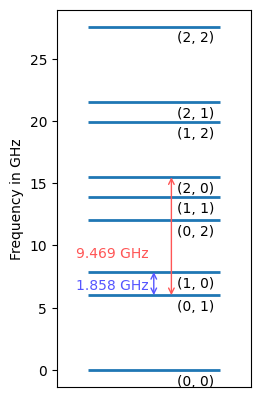

In [8]:
def plotEnergyLevelsDressed(model):
    model.set_dressed(True)
    H = np.real(model.get_Hamiltonian().numpy())/(2*np.pi*1e9)
    states_to_plot = [(0,0), (0,1), (0,2), (1,0), (1,1), (1,2), (2,0), (2,1), (2,2)]
    state_indices = model.get_state_indeces(states_to_plot)
    energies = [H[i,i] for i in state_indices]
    states_diff = [(1,0), (0,1), (2,0)]
    states_diff_index = model.get_state_indeces(states_diff)
    states_diff_energy = [H[i,i] for i in states_diff_index]
    energy_diff = np.abs(np.ediff1d(states_diff_energy))

    x = [1]*len(states_to_plot)
    plt.figure(figsize=(2.5,5), dpi=100)
    plt.scatter(x, energies, s=9000, marker="_", linewidth=2, zorder=3)
    
    cmap = plt.cm.get_cmap("seismic", 4)

    for xi,yi,tx in zip(x,energies,states_to_plot):
        plt.annotate(tx, xy=(xi,yi), xytext=(30,-3), size=10,
                    ha="center",va='top', textcoords="offset points")
    for i in range(1,len(states_diff)):
        plt.annotate(text='', xy=(1+(i-1)*0.01,states_diff_energy[i-1]), 
                    xytext=(1+(i-1)*0.01,states_diff_energy[i]), 
                    arrowprops=dict(arrowstyle='<->', shrinkA=0, shrinkB=0, color=cmap(i)))
        plt.annotate(f"{round(energy_diff[i-1],3)} GHz", xy=(1,states_diff_energy[i-1]), xytext=(-30,-5 + (i-1)*40), size=10,
                    ha="center",va='top', textcoords="offset points", color=cmap(i))

    plt.xticks([])
    plt.ylabel("Frequency in GHz")
    plt.savefig("Energy Levels.png")
    plt.show()
    model.set_dressed(False)
    model.update_model()

plotEnergyLevelsDressed(model)

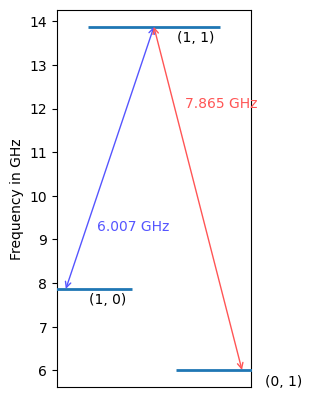

In [9]:
def plotLambdaSystem(model):
    model.set_dressed(True)
    H = np.real(model.get_Hamiltonian().numpy())/(2*np.pi*1e9)
    states_to_plot = [(1,0), (1,1), (0,1)]
    state_indices = model.get_state_indeces(states_to_plot)
    energies = [H[i,i] for i in state_indices]
    states_diff = [(1,0), (1,1), (0,1)]
    states_diff_index = model.get_state_indeces(states_diff)
    states_diff_energy = [H[i,i] for i in states_diff_index]
    energy_diff = np.abs(np.ediff1d(states_diff_energy))

    x = [1,2,3]
    plt.figure(figsize=(2.5,5), dpi=100)
    plt.scatter(x, energies, s=9000, marker="_", linewidth=2, zorder=3)
    
    cmap = plt.cm.get_cmap("seismic", 4)

    for xi,yi,tx in zip(x,energies,states_to_plot):
        plt.annotate(tx, xy=(xi,yi), xytext=(30,-3), size=10,
                    ha="center",va='top', textcoords="offset points")
    for i in range(1,len(states_diff)):
        plt.annotate(text='', xy=(i,states_diff_energy[i-1]), 
                    xytext=(i+1,states_diff_energy[i]), 
                    arrowprops=dict(arrowstyle='<->', shrinkA=0, shrinkB=0, color=cmap(i)))
        plt.annotate(f"{round(energy_diff[i-1],3)} GHz", xy=(i+1,states_diff_energy[i-1]), xytext=(-15, 50 - (i-1)*100), size=10,
                    ha="center",va='top', textcoords="offset points", color=cmap(i))

    plt.xticks([])
    plt.ylabel("Frequency in GHz")
    plt.savefig("Energy Levels.png")
    plt.show()
    model.set_dressed(False)
    model.update_model()

plotLambdaSystem(model)

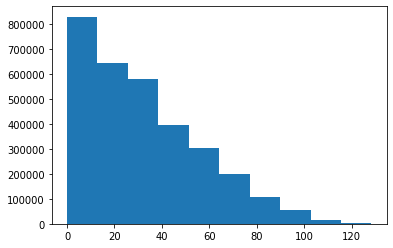

In [10]:
def calculateAllGaps(model):
    model.set_dressed(True)
    H = np.real(model.get_Hamiltonian().numpy())/(2*np.pi*1e9)
    N = len(H)
    energies = [H[i,i] for i in range(N)]
    gaps = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            gaps[i,j] = np.abs(energies[i] - energies[j])

    gaps_sorted_list = np.sort(np.triu(gaps,k=0).flatten())
    gaps_sorted_list = gaps_sorted_list[gaps_sorted_list != 0]
    gaps_diff = []
    for i in gaps_sorted_list:
        for j in gaps_sorted_list:
            gaps_diff.append(np.abs(i - j))
    gaps_diff = np.sort(gaps_diff)
    #print(gaps_diff.tolist())
    plt.hist(gaps_diff)


    model.set_dressed(False)
    model.update_model()

calculateAllGaps(model)

### Qubit X gate

In [13]:
t_X_gate = 15e-9
sideband = 50e6
gauss_params = {
    "amp": Qty(value=0.5,min_val=0.2,max_val=0.6,unit="V"),
    "t_final": Qty(value=t_X_gate,min_val=0.5 * t_X_gate,max_val=1.5 * t_X_gate,unit="s"),
    "sigma": Qty(value=t_X_gate / 4,min_val=t_X_gate / 8,max_val=t_X_gate / 2,unit="s"),
    "xy_angle": Qty(value=0.0,min_val=-0.5 * np.pi,max_val=2.5 * np.pi,unit="rad"),
    "freq_offset": Qty(value=-sideband - 3e6,min_val=-56 * 1e6,max_val=-52 * 1e6,unit="Hz 2pi"),
    "delta": Qty(value=-1,min_val=-5,max_val=3,unit="")
}

gauss_pulse = pulse.Envelope(
    name="gauss",
    desc="Gaussian comp for single qubit gates",
    params=gauss_params,
    shape=envelopes.gaussian_nonorm
)

nodrive_pulse = pulse.Envelope(
    name="no_drive",
    params={
        "t_final": Qty(
            value=t_X_gate,
            min_val=0.5 * t_X_gate,
            max_val=1.5 * t_X_gate,
            unit="s"
        )
    },
    shape=envelopes.no_drive
)

## Create carriers
qubit_freqs = model.get_qubit_freqs()
carriers = createCarriers(qubit_freqs, sideband)

qubit_pulse = copy.deepcopy(gauss_pulse)
resonator_pulse = copy.deepcopy(nodrive_pulse)
X_gate = gates.Instruction(
    name="x", targets=[0], t_start=0.0, t_end=t_X_gate, channels=["dQ", "dR"]
)
X_gate.add_component(qubit_pulse, "dQ")
X_gate.add_component(copy.deepcopy(carriers[0]), "dQ")
X_gate.add_component(resonator_pulse, "dR")
X_gate.add_component(copy.deepcopy(carriers[1]), "dR")

single_q_gates = [X_gate]

In [ ]:
parameter_map = PMap(instructions=single_q_gates, model=model, generator=generator)
exp = Exp(pmap=parameter_map)
exp.set_opt_gates(['x[0]'])
unitaries = exp.compute_propagators()

psi_init = [[0] * model.tot_dim]
psi_init[0][0] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
sequence = ['x[0]']
plotPopulation(exp=exp, psi_init=init_state, sequence=sequence, usePlotly=False)

Optimize the X gate

In [ ]:
parameter_map.set_opt_map([
    [("x[0]", "dQ", "gauss", "amp")],
    [("x[0]", "dQ", "gauss", "freq_offset")],
    [("x[0]", "dQ", "gauss", "xy_angle")],
    [("x[0]", "dQ", "gauss", "delta")],
    [("x[0]", "dR", "carrier", "framechange")]
])

parameter_map.print_parameters()

opt = OptimalControl(
    dir_path="./output/",
    fid_func=fidelities.average_infid_set,
    fid_subspace=["Q", "R"],
    pmap=parameter_map,
    algorithm=algorithms.lbfgs,
    options={"maxfun": 150},
    run_name="better_x"
)
exp.set_opt_gates(["x[0]"])
opt.set_exp(exp)

opt.optimize_controls()
opt.current_best_goal

plotPopulation(exp=exp, psi_init=init_state, sequence=sequence, usePlotly=False)


### Readout of Resonator

In [12]:
def calculateState(
    exp: Experiment,
    psi_init: tf.Tensor,
    sequence: List[str]
):

    """
    Calculates the state of system with time.

    Parameters
    ----------
    exp: Experiment,
        The experiment containing the model and propagators
    psi_init: tf.Tensor,
        Initial state vector
    sequence: List[str]
        List of gate names that will be applied to the state

    Returns
    -------
    psi_list: List[tf.Tensor]
        List of states
    """

    model = exp.pmap.model
    dUs = exp.partial_propagators
    if model.lindbladian:
        psi_t = tf_utils.tf_dm_to_vec(psi_init)
    else:
        psi_t = psi_init
    #psi_list = [psi_t]
    psi_list = []
    for gate in sequence:
        for du in dUs[gate]:
            psi_t = tf.matmul(du, psi_t)
            psi_list.append(psi_t)

    return psi_list


def calculateExpectationValue(states, Op, lindbladian):
    expect_val = []
    for i in states:
        if lindbladian:
            expect_val.append(tf.linalg.trace(tf.matmul(i, Op)))
        else:
            expect_val.append(tf.matmul(tf.matmul(tf.transpose(i, conjugate=True), Op),i)[0,0])
    return expect_val



def frameOfDrive(exp, psi_list, freq_q, freq_r, spacing):
    model = exp.pmap.model
    aR = tf.convert_to_tensor(model.ann_opers[1], dtype = tf.complex128)
    aQ = tf.convert_to_tensor(model.ann_opers[0], dtype = tf.complex128)

    n = len(psi_list)

    aR_dag = tf.transpose(aR, conjugate=True)
    NR = tf.matmul(aR_dag,aR)

    aQ_dag = tf.transpose(aQ, conjugate=True)
    NQ = tf.matmul(aQ_dag, aQ)

    ts = exp.ts[::spacing]
    ts = tf.cast(ts, dtype=tf.complex128)
    
    I = tf.eye(len(aR), dtype=tf.complex128)
    
    psi_rotated = []
    
    for i in range(n):
        U = tf.linalg.expm(1j*2*np.pi*(freq_r*NR + freq_q*NQ)*ts[i])
        if model.lindbladian:
            U_dag = tf.transpose(U, conjugate=True)
            rho_i = tf_utils.tf_vec_to_dm(psi_list[i])
            psi_rotated.append(tf.matmul(tf.matmul(U_dag, rho_i), U))    ## Check this. Now it is U_dag*rho*U but I think it should be U*rho*U_dag
        else:
            psi_rotated.append(tf.matmul(U, psi_list[i]))

    return psi_rotated

def plotIQ(
        exp: Experiment, 
        sequence: List[str], 
        annihilation_operator: tf.Tensor,
        drive_freq_q,
        drive_freq_r,
        spacing=100,
        usePlotly=False
):
    
    """
    Calculate and plot the I-Q values for resonator 

    Parameters
    ----------
    exp: Experiment,
 
    sequence: List[str], 

    annihilation_operator: tf.Tensor

    Returns
    -------
        
    """
    model = exp.pmap.model
    annihilation_operator = tf.convert_to_tensor(annihilation_operator, dtype=tf.complex128)
    
    state_index = exp.pmap.model.get_state_index((0,0))
    psi_init_0 = [[0] * model.tot_dim]
    psi_init_0[0][state_index] = 1
    init_state_0 = tf.transpose(tf.constant(psi_init_0, tf.complex128))
    
    if model.lindbladian:
        init_state_0 = tf_utils.tf_state_to_dm(init_state_0)

    psi_list = calculateState(exp, init_state_0, sequence)
    psi_list = psi_list[::spacing]
    psi_list_0 =  frameOfDrive(exp, psi_list, drive_freq_q, drive_freq_r, spacing)
    expect_val_0 = calculateExpectationValue(psi_list_0, annihilation_operator, model.lindbladian)
    Q0 = np.real(expect_val_0)
    I0 = np.imag(expect_val_0)
    

    state_index = exp.pmap.model.get_state_index((1,0))
    psi_init_1 = [[0] * model.tot_dim]
    psi_init_1[0][state_index] = 1
    init_state_1 = tf.transpose(tf.constant(psi_init_1, tf.complex128))
    
    if model.lindbladian:
        init_state_1 = tf_utils.tf_state_to_dm(init_state_1)

    psi_list = calculateState(exp, init_state_1, sequence)
    psi_list = psi_list[::spacing]
    psi_list_1 =  frameOfDrive(exp, psi_list, drive_freq_q, drive_freq_r, spacing)
    expect_val_1 = calculateExpectationValue(psi_list_1, annihilation_operator, model.lindbladian)
    Q1 = np.real(expect_val_1)
    I1 = np.imag(expect_val_1)

    ts = exp.ts[::spacing]
    dist = []
    for t in range(len(ts)):
        dist.append(np.sqrt((Q0[t] - Q1[t])**2 + (I0[t] - I1[t])**2))
    
    if usePlotly:
        fig = go.Figure()
        fig.add_trace(go.Scatter(x = Q0, y = I0, mode = "lines", name="Ground state"))
        fig.add_trace(go.Scatter(x = Q1, y = I1, mode = "lines", name ="Excited state"))
        fig.show()
        #fig.write_image("Readout_IQ.png")
    else:
        plt.figure(dpi=100)
        plt.plot(Q0, I0, label="Ground state", linestyle='--', marker='o')
        plt.plot(Q1, I1, label="Excited state", linestyle='--', marker='o')
        plt.legend()
        plt.show()
        #plt.savefig("IQ Plot 2.png")
    
    plt.figure(dpi=100)
    plt.plot(ts, dist)
    plt.xlabel("Time (in seconds)")
    plt.ylabel("Distance (in arbitrary units)")
    plt.show()
    #plt.savefig("Distance plot 2.png")


Define readout pulse for the resonator

In [32]:
qubit_freqs = model.get_qubit_freqs()
sideband = 50e6

Delta_1 = qubit_frequency - resonator_frequency
Delta_2 = (2 + qubit_anharm)*qubit_frequency
chi_0 = (coupling_strength**2)/Delta_1
chi_1 = (coupling_strength**2)/(Delta_2 - Delta_1)

carriers = createCarriers([resonator_frequency+sideband - chi_1/2, resonator_frequency+sideband - chi_1/2], sideband)

t_readout = 60e-9
sideband = 50e6
readout_params = {
    "amp": Qty(value=2*np.pi*0.005,min_val=0.0,max_val=100.0,unit="V"),
    "t_final": Qty(value=t_readout,min_val=0.5 * t_readout,max_val=1.5 * t_readout,unit="s"),
    "sigma": Qty(value=t_readout / 4,min_val=t_readout / 8,max_val=t_readout / 2,unit="s"),
    "xy_angle": Qty(value=0.0,min_val=-0.5 * np.pi,max_val=2.5 * np.pi,unit="rad"),
    "freq_offset": Qty(value=-sideband - 3e6,min_val=-56 * 1e6,max_val=-52 * 1e6,unit="Hz 2pi"),
    "delta": Qty(value=-1,min_val=-5,max_val=3,unit="")
}

readout_pulse = pulse.Envelope(
    name="readout",
    desc="Gaussian pulse for readout",
    params=readout_params,
    shape=envelopes.gaussian_nonorm
)

nodrive_pulse = pulse.Envelope(
    name="no_drive",
    params={
        "t_final": Qty(
            value=t_readout,
            min_val=0.5 * t_readout,
            max_val=1.5 * t_readout,
            unit="s"
        )
    },
    shape=envelopes.no_drive
)

qubit_pulse = copy.deepcopy(nodrive_pulse)
resonator_pulse = copy.deepcopy(readout_pulse)
Readout_gate = gates.Instruction(
    name="Readout", targets=[1], t_start=0.0, t_end=t_readout, channels=["dR", "dQ"]
)
Readout_gate.add_component(qubit_pulse, "dQ")
Readout_gate.add_component(copy.deepcopy(carriers[0]), "dQ")
Readout_gate.add_component(resonator_pulse, "dR")
Readout_gate.add_component(copy.deepcopy(carriers[1]), "dR")

readout_gates = [Readout_gate]

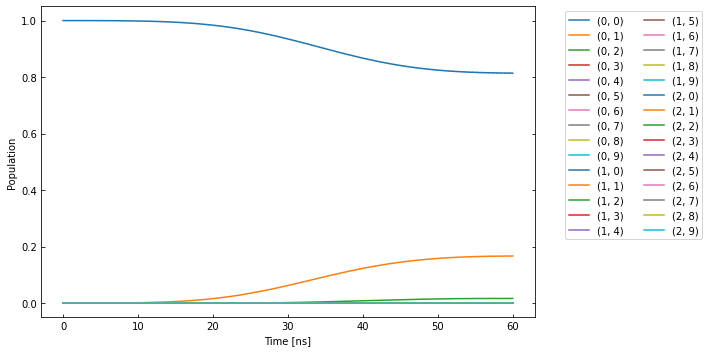

In [33]:
parameter_map = PMap(instructions=readout_gates, model=model, generator=generator)
exp = Exp(pmap=parameter_map)

model.use_FR = False
exp.use_control_fields = False

exp.set_opt_gates(['Readout[1]'])
unitaries = exp.compute_propagators()

psi_init = [[0] * model.tot_dim]
psi_init[0][0] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
sequence = ['Readout[1]']
plotPopulation(exp=exp, psi_init=init_state, sequence=sequence, usePlotly=False)


In [ ]:
plotNumberOperator(exp, init_state, sequence)

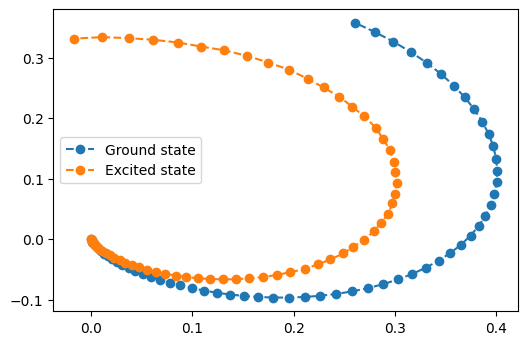

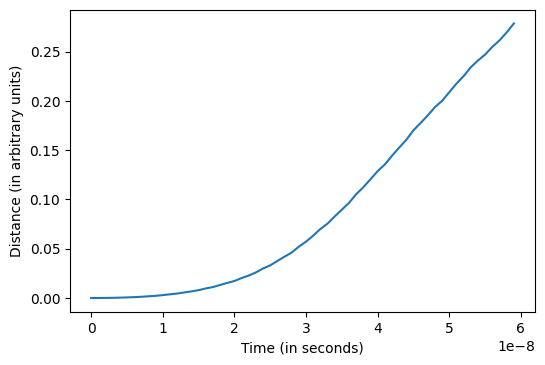

In [29]:
plotIQ(exp, sequence, model.ann_opers[1], resonator_frequency, resonator_frequency, spacing=100, usePlotly=False)

### Qubit Resonator SWAP

Generating Ideal Gate - 

In [9]:
from qutip import *
import numpy as np
Nq = 3
Nr = 3
Ideal_gate = np.array(tensor(qeye(Nq), qeye(Nr)) + tensor(basis(Nq,1),basis(Nr,0))*tensor(basis(Nq,0),basis(Nr,1)).dag() + tensor(basis(Nq,0),basis(Nr,1))*tensor(basis(Nq,1),basis(Nr,0)).dag() - tensor(basis(Nq,1),basis(Nr,0))*tensor(basis(Nq,1),basis(Nr,0)).dag() - tensor(basis(Nq,0),basis(Nr,1))*tensor(basis(Nq,0),basis(Nr,1)).dag()) 
print(Ideal_gate)
np.savetxt("ideal_gate.csv", Ideal_gate, delimiter=",")

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]]


Define SWAP gate for qubit and resonator by using Rabi oscillations

In [18]:
t_swap_gate = 250e-9
sideband = 50e6

tswap_10_20 = 20e-9
tswap_20_01 = 220e-9


Qswap_params = {
    "amp": Qty(value=1.0,min_val=0.0,max_val=10.0,unit="V"),
    "t_up": Qty(value=2.0e-9, min_val=0.0, max_val=tswap_10_20, unit="s"),
    "t_down": Qty(value=tswap_10_20-2.0e-9, min_val=0.0, max_val=tswap_10_20, unit="s"),
    "risefall": Qty(value=1.0e-9, min_val=0.1e-9, max_val=tswap_10_20/2, unit="s"),
    "xy_angle": Qty(value=0.0,min_val=-0.5 * np.pi,max_val=2.5 * np.pi,unit="rad"),
    "freq_offset": Qty(value=-sideband - 3e6,min_val=-56 * 1e6,max_val=-52 * 1e6,unit="Hz 2pi"),
    "delta": Qty(value=-1,min_val=-5,max_val=3,unit=""),
    "t_final": Qty(value=t_swap_gate,min_val=0.1*t_swap_gate,max_val=1.5*t_swap_gate,unit="s")
}

Qswap2_params = {
    "amp": Qty(value=1.0,min_val=0.0,max_val=10.0,unit="V"),
    "t_up": Qty(value=t_swap_gate - tswap_20_01, min_val=0.0, max_val=tswap_20_01, unit="s"),
    "t_down": Qty(value=t_swap_gate-2.0e-9, min_val=0.0, max_val=t_swap_gate, unit="s"),
    "risefall": Qty(value=1.0e-9, min_val=0.1e-9, max_val=t_swap_gate/2, unit="s"),
    "xy_angle": Qty(value=0.0,min_val=-0.5 * np.pi,max_val=2.5 * np.pi,unit="rad"),
    "freq_offset": Qty(value=-sideband - 3e6,min_val=-56 * 1e6,max_val=-52 * 1e6,unit="Hz 2pi"),
    "delta": Qty(value=-1,min_val=-5,max_val=3,unit=""),
    "t_final": Qty(value=t_swap_gate,min_val=0.1*t_swap_gate,max_val=1.5*t_swap_gate,unit="s")
}

Qswap_pulse = pulse.Envelope(
    name="swap_pulse",
    desc="Flattop pluse for SWAP gate",
    params=Qswap_params,
    shape=envelopes.flattop
)

Qswap2_pulse = pulse.Envelope(
    name="swap2_pulse",
    desc="Flattop pluse for SWAP gate",
    params=Qswap2_params,
    shape=envelopes.flattop
)

Rswap_params = {
    "amp": Qty(value=1.0,min_val=0.0,max_val=10.0,unit="V"),
    "t_up": Qty(value=2.0e-9, min_val=0.0, max_val=tswap_10_20, unit="s"),
    "t_down": Qty(value=tswap_10_20-2.0e-9, min_val=0.0, max_val=tswap_10_20, unit="s"),
    "risefall": Qty(value=1.0e-9, min_val=0.1e-9, max_val=tswap_10_20/2, unit="s"),
    "xy_angle": Qty(value=0.0,min_val=-0.5 * np.pi,max_val=2.5 * np.pi,unit="rad"),
    "freq_offset": Qty(value=-sideband - 3e6,min_val=-56 * 1e6,max_val=-52 * 1e6,unit="Hz 2pi"),
    "delta": Qty(value=-1,min_val=-5,max_val=3,unit=""),
    "t_final": Qty(value=t_swap_gate,min_val=0.1*t_swap_gate,max_val=1.5*t_swap_gate,unit="s")
}


Rswap2_params = {
    "amp": Qty(value=1.0,min_val=0.0,max_val=10.0,unit="V"),
    "t_up": Qty(value=t_swap_gate - tswap_20_01, min_val=0.0, max_val=tswap_20_01, unit="s"),
    "t_down": Qty(value=t_swap_gate-2.0e-9, min_val=0.0, max_val=t_swap_gate, unit="s"),
    "risefall": Qty(value=1.0e-9, min_val=0.1e-9, max_val=t_swap_gate/2, unit="s"),
    "xy_angle": Qty(value=0.0,min_val=-0.5 * np.pi,max_val=2.5 * np.pi,unit="rad"),
    "freq_offset": Qty(value=-sideband - 3e6,min_val=-56 * 1e6,max_val=-52 * 1e6,unit="Hz 2pi"),
    "delta": Qty(value=-1,min_val=-5,max_val=3,unit=""),
    "t_final": Qty(value=t_swap_gate,min_val=0.1*t_swap_gate,max_val=1.5*t_swap_gate,unit="s")
}


Rswap_pulse = pulse.Envelope(
    name="swap_pulse",
    desc="Flattop pluse for SWAP gate",
    params=Rswap_params,
    shape=envelopes.flattop
)

Rswap2_pulse = pulse.Envelope(
    name="swap2_pulse",
    desc="Flattop pluse for SWAP gate",
    params=Rswap2_params,
    shape=envelopes.flattop
)


nodrive_pulse = pulse.Envelope(
    name="no_drive",
    params={
        "t_final": Qty(
            value=t_swap_gate,
            min_val=0.5 * t_swap_gate,
            max_val=1.5 * t_swap_gate,
            unit="s"
        )
    },
    shape=envelopes.no_drive
)


tlist = np.linspace(0,t_swap_gate, 1000)
#plotSignal(tlist, Qswap_pulse.shape(tlist, Qswap_pulse.params).numpy())
#plotSignal(tlist, Qswap2_pulse.shape(tlist, Qswap2_pulse.params).numpy())
#plotSignal(tlist, Rswap_pulse.shape(tlist, Rswap_pulse.params).numpy())
#plotSignal(tlist, Rswap2_pulse.shape(tlist, Rswap2_pulse.params).numpy())

#index = model.get_state_indeces([(1,0),(0,1)])
#state_energies = [model.eigenframe[i].numpy() for i in index]
#print(abs(state_energies[0] - state_energies[1])/(2*np.pi*1e9))


drive_freq_qubit = 7.5e9
drive_freq_resonator = 7.5e9
carrier_freq = [drive_freq_qubit, drive_freq_resonator]
carrier_parameters = {
            "Q":{"freq": Qty(value=carrier_freq[0], min_val=0.0, max_val=10e9, unit="Hz 2pi"),
            "framechange": Qty(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit="rad")},
            "R": {"freq": Qty(value=carrier_freq[1], min_val=0.0, max_val=10e9, unit="Hz 2pi"),
            "framechange": Qty(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit="rad")}
            }

carriers = [
    pulse.Carrier(name="carrier", desc="Frequency of the local oscillator", params=carrier_parameters["Q"]),
    pulse.Carrier(name="carrier", desc="Frequency of the local oscillator", params=carrier_parameters["R"])
]


drive_freq_qubit = 9.5095e9
drive_freq_resonator = 9.5095e9
carrier_freq = [drive_freq_qubit, drive_freq_resonator]
carrier_parameters = {
            "Q":{"freq": Qty(value=carrier_freq[0], min_val=0.0, max_val=10e9, unit="Hz 2pi"),
            "framechange": Qty(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit="rad")},
            "R": {"freq": Qty(value=carrier_freq[1], min_val=0.0, max_val=10e9, unit="Hz 2pi"),
            "framechange": Qty(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit="rad")}
            }

carriers_2 = [
    pulse.Carrier(name="carrier2", desc="Frequency of the local oscillator", params=carrier_parameters["Q"]),
    pulse.Carrier(name="carrier2", desc="Frequency of the local oscillator", params=carrier_parameters["R"])
]

ideal_gate = np.loadtxt("ideal_gate.csv", delimiter=",", dtype=np.complex128)

swap_gate = gates.Instruction(
    name="swap", targets=[0, 1], t_start=0.0, t_end=t_swap_gate, channels=["dQ", "dR"], 
    ideal=ideal_gate
)
swap_gate.set_ideal(ideal_gate)

swap_gate.add_component(Qswap_pulse, "dQ")
swap_gate.add_component(copy.deepcopy(carriers[0]), "dQ")

#swap_gate.add_component(Qswap2_pulse, "dQ")
#swap_gate.add_component(copy.deepcopy(carriers_2[0]), "dQ")

swap_gate.add_component(Rswap_pulse, "dR")
swap_gate.add_component(copy.deepcopy(carriers[1]), "dR")

#swap_gate.add_component(Rswap2_pulse, "dR")
#swap_gate.add_component(copy.deepcopy(carriers_2[1]), "dR")


gates_arr = [swap_gate]

In [19]:
swap_gate.get_ideal_gate(dims = (3,3), full_hilbert_space=True)

<tf.Tensor: shape=(9, 9), dtype=complex128, numpy=
array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j,
        0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j,
        0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        1.+0.j]])>

In [14]:
parameter_map = PMap(instructions=gates_arr, model=model, generator=generator)
exp = Exp(pmap=parameter_map)
exp.set_opt_gates(['swap[0, 1]'])
unitaries = exp.compute_propagators()
#plotComplexMatrix(unitaries['swap[0, 1]'].numpy())

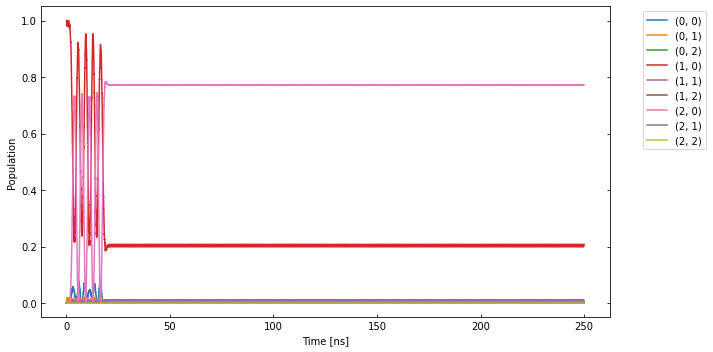

In [15]:
init_state_index = model.get_state_indeces([(1,0)])[0]
psi_init = [[0] * model.tot_dim]
psi_init[0][init_state_index] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
sequence = ['swap[0, 1]']
plotPopulation(exp=exp, psi_init=init_state, sequence=sequence, usePlotly=False)

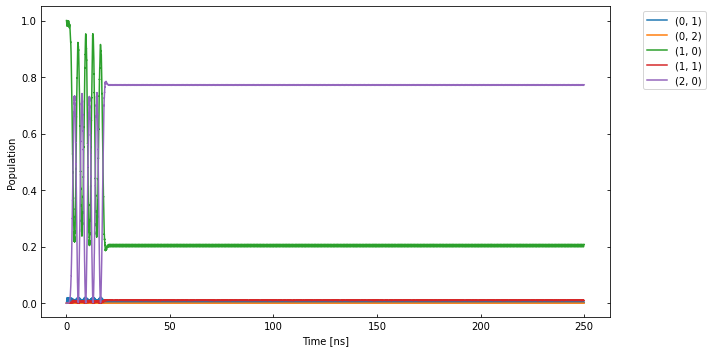

In [34]:
states_to_plot = [(0,1), (1,0), (0,2), (2,0), (1,1)]
plotPopulation(exp=exp, psi_init=init_state, sequence=sequence, states_to_plot=states_to_plot, usePlotly=False)

In [ ]:
exp.write_config("qubit_reset_experiment.hjson")

Optimization

In [ ]:
parameter_map.set_opt_map([
    [("swap[0, 1]", "dR", "carrier", "freq")],
    [("swap[0, 1]", "dR", "swap_pulse", "amp")],
    [("swap[0, 1]", "dR", "swap_pulse", "t_up")],
    [("swap[0, 1]", "dR", "swap_pulse", "t_down")],
    [("swap[0, 1]", "dR", "swap_pulse", "risefall")],
    [("swap[0, 1]", "dR", "swap_pulse", "xy_angle")],
    [("swap[0, 1]", "dR", "swap_pulse", "freq_offset")],
    [("swap[0, 1]", "dR", "swap_pulse", "delta")],
    [("swap[0, 1]", "dQ", "carrier", "freq")],
    [("swap[0, 1]", "dQ", "swap_pulse", "amp")],
    [("swap[0, 1]", "dQ", "swap_pulse", "t_up")],
    [("swap[0, 1]", "dQ", "swap_pulse", "t_down")],
    [("swap[0, 1]", "dQ", "swap_pulse", "risefall")],
    [("swap[0, 1]", "dQ", "swap_pulse", "xy_angle")],
    [("swap[0, 1]", "dQ", "swap_pulse", "freq_offset")],
    [("swap[0, 1]", "dQ", "swap_pulse", "delta")],
])

parameter_map.print_parameters()

opt = OptimalControl(
    dir_path="./output/",
    fid_func=fidelities.state_transfer_infid_set_full,
    fid_subspace=["Q", "R"],
    pmap=parameter_map,
    algorithm=algorithms.lbfgs,
    options={"maxfun":200},
    run_name="SWAP_20_01",
    fid_func_kwargs={"psi_0":init_state}
)
exp.set_opt_gates(["swap[0, 1]"])
opt.set_exp(exp)

opt.optimize_controls()
print(opt.current_best_goal)
print(parameter_map.print_parameters())

In [ ]:
plotPopulation(exp=exp, psi_init=init_state, sequence=sequence, usePlotly=False)

In [ ]:
plotPopulation(exp=exp, psi_init=init_state, sequence=sequence, usePlotly=False, states_to_plot=states_to_plot)

### Readout with dissipation

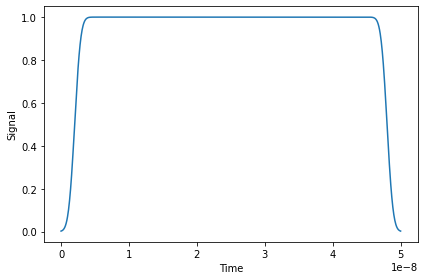

/home/ubuntu/Ashutosh_files/c3_reset/c3/c3/signal/gates.py:102: UserWarning: No ideal gate found for gate: Readout. Use set_ideal() explicitly.
  warnings.warn(


In [9]:
model.set_lindbladian(True)

qubit_freqs = model.get_qubit_freqs()
sideband = 50e6

Delta_1 = qubit_frequency - resonator_frequency
Delta_2 = (2 + qubit_anharm)*qubit_frequency
chi_0 = (coupling_strength**2)/Delta_1
chi_1 = (coupling_strength**2)/(Delta_2 - Delta_1)

carriers = createCarriers([resonator_frequency+sideband - chi_1/2, resonator_frequency+sideband - chi_1/2], sideband)

t_readout = 50e-9
t_total = 50e-9
sideband = 50e6


readout_params = {
    "amp": Qty(value=2*np.pi*0.01,min_val=0.0,max_val=10.0,unit="V"),
    "t_up": Qty(value=2e-9, min_val=0.0, max_val=t_readout, unit="s"),
    "t_down": Qty(value=t_readout-2.0e-9, min_val=0.0, max_val=t_readout, unit="s"),
    "risefall": Qty(value=1.0e-9, min_val=0.1e-9, max_val=t_readout/2, unit="s"),
    "xy_angle": Qty(value=np.pi,min_val=-0.5 * np.pi,max_val=2.5 * np.pi,unit="rad"),
    "freq_offset": Qty(value=-sideband - 3e6,min_val=-56 * 1e6,max_val=-52 * 1e6,unit="Hz 2pi"),
    "delta": Qty(value=-1,min_val=-5,max_val=3,unit=""),
    "t_final": Qty(value=t_total,min_val=0.1*t_total,max_val=1.5*t_total,unit="s")
}

readout_pulse = pulse.Envelope(
    name="readout-pulse",
    desc="Flattop pluse for SWAP gate",
    params=readout_params,
    shape=envelopes.flattop
)


tlist = np.linspace(0,t_total, 1000)
plotSignal(tlist, readout_pulse.shape(tlist, readout_pulse.params).numpy())

nodrive_pulse = pulse.Envelope(
    name="no_drive", 
    params={
        "t_final": Qty(
            value=t_total,
            min_val=0.5 * t_total,
            max_val=1.5 * t_total,
            unit="s"
        )
    },
    shape=envelopes.no_drive
)

qubit_pulse = copy.deepcopy(readout_pulse)
qubit_pulse.params["amp"] = Qty(value=2*np.pi*0,min_val=0.0,max_val=10.0,unit="V")
qubit_pulse.params["xy_angle"] = Qty(value=0,min_val=-0.5 * np.pi,max_val=2.5 * np.pi,unit="rad")
resonator_pulse = copy.deepcopy(readout_pulse)
resonator_pulse.params["amp"] = Qty(value=2*np.pi*0.01,min_val=0.0,max_val=10.0,unit="V")
resonator_pulse.params["xy_angle"] = Qty(value=-np.pi,min_val=-np.pi,max_val=2.5 * np.pi,unit="rad")
Readout_gate = gates.Instruction(
    name="Readout", targets=[1], t_start=0.0, t_end=t_total, channels=["dQ", "dR"]
)
Readout_gate.add_component(qubit_pulse, "dQ")
Readout_gate.add_component(copy.deepcopy(carriers[0]), "dQ")
Readout_gate.add_component(resonator_pulse, "dR")
Readout_gate.add_component(copy.deepcopy(carriers[1]), "dR")

readout_gates = [Readout_gate]


parameter_map = PMap(instructions=readout_gates, model=model, generator=generator)
exp = Exp(pmap=parameter_map)

In [10]:
model.set_FR(False)
model.set_lindbladian(True)
exp.set_opt_gates(['Readout[1]'])
exp.propagate_batch_size = 1000

In [11]:
unitaries = exp.compute_propagators()
print(unitaries)

{'Readout[1]': <tf.Tensor: shape=(81, 81), dtype=complex128, numpy=
array([[ 2.56017692e-01+1.55345524e-16j, -2.42630671e-01-1.69788912e-01j,
         2.49627289e-01+1.94252754e-01j, ...,
         6.27105226e-06-1.46756981e-06j, -1.95133276e-06+5.12450170e-08j,
         2.13881337e-06-4.15010446e-20j],
       [-2.89828577e-01+6.17518977e-02j,  1.30467620e-01-1.64486430e-01j,
         3.42832305e-01-4.76027997e-02j, ...,
         3.94241808e-06+3.80277870e-06j,  4.55044248e-07-1.25750607e-06j,
         1.51295043e-06+5.16849174e-07j],
       [ 1.73559771e-01-2.64821786e-01j,  1.96675365e-01-2.84848251e-01j,
        -4.66336386e-02-1.73256286e-01j, ...,
         5.45414628e-06-9.70543145e-06j, -7.55045337e-06-1.61667567e-06j,
         2.47620367e-06+3.29690242e-07j],
       ...,
       [ 5.57321611e-06-8.05718756e-07j,  2.32395024e-06+4.10178543e-06j,
         1.04815162e-05+3.88465699e-06j, ...,
         5.04943140e-01-7.27720128e-01j,  8.57208199e-02-2.54905787e-01j,
        -4.3243303

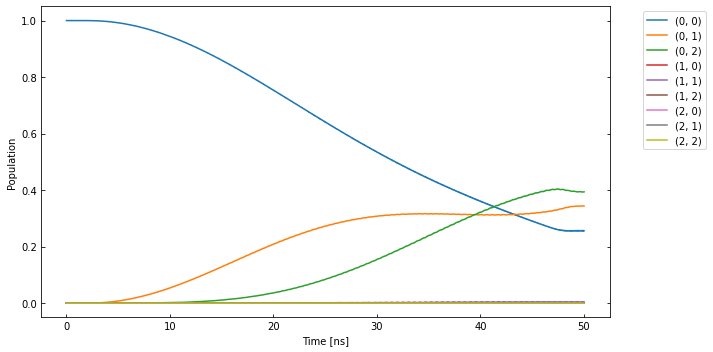

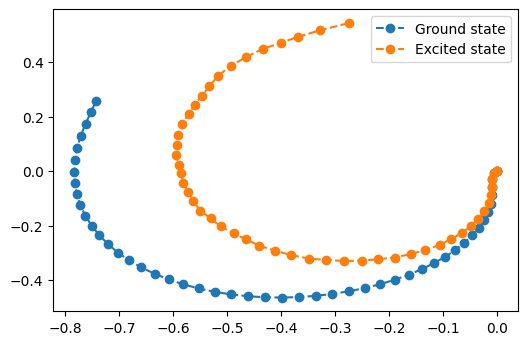

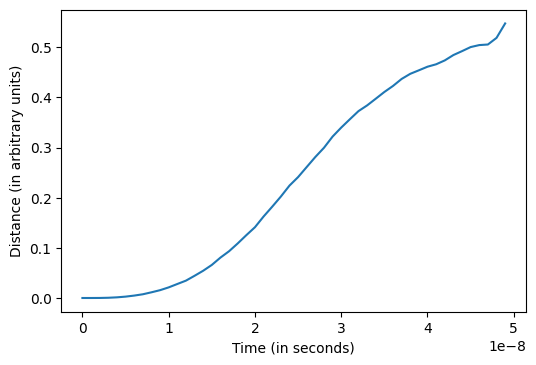

In [38]:
psi_init = [[0] * model.tot_dim]
init_state_index = model.get_state_indeces([(0,0)])[0]
psi_init[0][init_state_index] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
if model.lindbladian:
    init_state = tf_utils.tf_state_to_dm(init_state)
sequence = ['Readout[1]']
plotPopulation(exp=exp, psi_init=init_state, sequence=sequence, usePlotly=False)#, filename="Test_master_pop_2.png")

plotIQ(exp, sequence, model.ann_opers[1], resonator_frequency, resonator_frequency, spacing=100, usePlotly=False)

Optimizing the readout pulse

In [39]:
print("######### Starting Optimization ##########")

parameter_map.set_opt_map([
    [("Readout[1]", "dR", "carrier", "freq")],
    [("Readout[1]", "dR", "readout-pulse", "amp")],
    [("Readout[1]", "dR", "readout-pulse", "t_up")],
    [("Readout[1]", "dR", "readout-pulse", "t_down")],
    [("Readout[1]", "dR", "readout-pulse", "risefall")],
    [("Readout[1]", "dR", "readout-pulse", "xy_angle")],
    [("Readout[1]", "dR", "readout-pulse", "freq_offset")],
    [("Readout[1]", "dR", "readout-pulse", "delta")],
    [("Readout[1]", "dQ", "carrier", "freq")],
    [("Readout[1]", "dQ", "readout-pulse", "amp")],
    [("Readout[1]", "dQ", "readout-pulse", "t_up")],
    [("Readout[1]", "dQ", "readout-pulse", "t_down")],
    [("Readout[1]", "dQ", "readout-pulse", "risefall")],
    [("Readout[1]", "dQ", "readout-pulse", "xy_angle")],
    [("Readout[1]", "dQ", "readout-pulse", "freq_offset")],
    [("Readout[1]", "dQ", "readout-pulse", "delta")],
])

parameter_map.print_parameters()

psi = [[0] * model.tot_dim]
ground_state_index = model.get_state_indeces([(0,0)])[0]
psi[0][ground_state_index] = 1
ground_state = tf.transpose(tf.constant(psi, tf.complex128))
if model.lindbladian:
    ground_state = tf_utils.tf_state_to_dm(ground_state)


psi = [[0] * model.tot_dim]
excited_state_index = model.get_state_indeces([(1,0)])[0]
psi[0][excited_state_index] = 1
excited_state = tf.transpose(tf.constant(psi, tf.complex128))
if model.lindbladian:
    excited_state = tf_utils.tf_state_to_dm(excited_state)


freq_drive = resonator_frequency

aR = tf.convert_to_tensor(model.ann_opers[1], dtype = tf.complex128)
aQ = tf.convert_to_tensor(model.ann_opers[0], dtype = tf.complex128)
aR_dag = tf.transpose(aR, conjugate=True)
NR = tf.matmul(aR_dag,aR)
aQ_dag = tf.transpose(aQ, conjugate=True)
NQ = tf.matmul(aQ_dag, aQ)

Urot = tf.linalg.expm(1j*2*np.pi*freq_drive*(NR + NQ)*t_total)
U_rot_dag = tf.transpose(Urot, conjugate=True)
a_rotated = tf.matmul(U_rot_dag, tf.matmul(aR, Urot))

d_max = 1.0

fid_params = {
    "ground_state": ground_state,
    "excited_state": excited_state,
    "a_rotated": a_rotated,
    "cutoff_distance": d_max,
    "lindbladian": model.lindbladian
}


opt = OptimalControl(
    dir_path="./output/",
    fid_func=fidelities.IQ_plane_distance,
    fid_subspace=["Q", "R"],
    pmap=parameter_map,
    algorithm=algorithms.lbfgs,
    options={"maxfun":250},
    run_name="Readout_IQ",
    fid_func_kwargs={"params":fid_params}
)
exp.set_opt_gates(["Readout[1]"])
opt.set_exp(exp)

######### Starting Optimization ##########
Readout[1]-dR-carrier-freq            : 6.070 GHz 2pi 
Readout[1]-dR-readout-pulse-amp       : 62.832 mV 
Readout[1]-dR-readout-pulse-t_up      : 2.000 ns 
Readout[1]-dR-readout-pulse-t_down    : 48.000 ns 
Readout[1]-dR-readout-pulse-risefall  : 1.000 ns 
Readout[1]-dR-readout-pulse-xy_angle  : -3.142 rad 
Readout[1]-dR-readout-pulse-freq_offset: -53.000 MHz 2pi 
Readout[1]-dR-readout-pulse-delta     : -1.000  
Readout[1]-dQ-carrier-freq            : 6.070 GHz 2pi 
Readout[1]-dQ-readout-pulse-amp       : 0.000 V 
Readout[1]-dQ-readout-pulse-t_up      : 2.000 ns 
Readout[1]-dQ-readout-pulse-t_down    : 48.000 ns 
Readout[1]-dQ-readout-pulse-risefall  : 1.000 ns 
Readout[1]-dQ-readout-pulse-xy_angle  : -444.089 arad 
Readout[1]-dQ-readout-pulse-freq_offset: -53.000 MHz 2pi 
Readout[1]-dQ-readout-pulse-delta     : -1.000  



In [ ]:
opt.optimize_controls()
print(opt.current_best_goal)
print(parameter_map.print_parameters())

In [ ]:
exp.write_config("Test_master_eq.hjson")
parameter_map.store_values("Test_master_eq_optimized_values_run1.c3log")

In [ ]:
plotPopulation(exp=exp, psi_init=init_state, sequence=sequence, usePlotly=False)
plotIQ(exp, sequence, model.ann_opers[1], resonator_frequency, resonator_frequency, spacing=100, usePlotly=False)

### Readout with disspation (smaller pulses)

In [8]:
qubit_freqs = model.get_qubit_freqs()
sideband = 50e6

Delta_1 = qubit_frequency - resonator_frequency
Delta_2 = (2 + qubit_anharm)*qubit_frequency
chi_0 = (coupling_strength**2)/Delta_1
chi_1 = (coupling_strength**2)/(Delta_2 - Delta_1)

carriers = createCarriers([resonator_frequency+sideband - chi_1/2, resonator_frequency+sideband - chi_1/2], sideband)

t_readout = 50e-9
t_total = 50e-9
t_up = 2e-9
t_down = 2e-9


up_params = {
    "amp": Qty(value=2*np.pi*0.01,min_val=0.0,max_val=10.0,unit="V"),
    "t_up": Qty(value=2e-9, min_val=0.0, max_val=t_readout, unit="s"),
    "t_down": Qty(value=t_readout-2.0e-9, min_val=0.0, max_val=t_readout, unit="s"),
    "risefall": Qty(value=1.0e-9, min_val=0.1e-9, max_val=t_readout/2, unit="s"),
    "xy_angle": Qty(value=np.pi,min_val=-0.5 * np.pi,max_val=2.5 * np.pi,unit="rad"),
    "freq_offset": Qty(value=-sideband - 3e6,min_val=-56 * 1e6,max_val=-52 * 1e6,unit="Hz 2pi"),
    "delta": Qty(value=-1,min_val=-5,max_val=3,unit=""),
    "t_final": Qty(value=t_total,min_val=0.1*t_total,max_val=1.5*t_total,unit="s")
}

readout_pulse = pulse.Envelope(
    name="readout-pulse",
    desc="Flattop pluse for SWAP gate",
    params=readout_params,
    shape=envelopes.flattop
)


tlist = np.linspace(0,t_total, 1000)
plotSignal(tlist, readout_pulse.shape(tlist, readout_pulse.params).numpy())

nodrive_pulse = pulse.Envelope(
    name="no_drive", 
    params={
        "t_final": Qty(
            value=t_total,
            min_val=0.5 * t_total,
            max_val=1.5 * t_total,
            unit="s"
        )
    },
    shape=envelopes.no_drive
)

qubit_pulse = copy.deepcopy(readout_pulse)
qubit_pulse.params["amp"] = Qty(value=2*np.pi*0,min_val=0.0,max_val=10.0,unit="V")
qubit_pulse.params["xy_angle"] = Qty(value=0,min_val=-0.5 * np.pi,max_val=2.5 * np.pi,unit="rad")
resonator_pulse = copy.deepcopy(readout_pulse)
resonator_pulse.params["amp"] = Qty(value=2*np.pi*0.01,min_val=0.0,max_val=10.0,unit="V")
resonator_pulse.params["xy_angle"] = Qty(value=-np.pi,min_val=-np.pi,max_val=2.5 * np.pi,unit="rad")
Readout_gate = gates.Instruction(
    name="Readout", targets=[1], t_start=0.0, t_end=t_total, channels=["dQ", "dR"]
)
Readout_gate.add_component(qubit_pulse, "dQ")
Readout_gate.add_component(copy.deepcopy(carriers[0]), "dQ")
Readout_gate.add_component(resonator_pulse, "dR")
Readout_gate.add_component(copy.deepcopy(carriers[1]), "dR")

readout_gates = [Readout_gate]


NameError: name 'readout_params' is not defined

### Resonator CLEAR pulse
Refer to - https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.5.011001

In [7]:
sideband = 50e6

Delta_1 = qubit_frequency - resonator_frequency
Delta_2 = (2 + qubit_anharm)*qubit_frequency
chi_0 = (coupling_strength**2)/Delta_1
chi_1 = (coupling_strength**2)/(Delta_2 - Delta_1)

carriers = createCarriers([resonator_frequency+sideband, resonator_frequency+sideband], sideband)


t1 = 20e-9
amp1 = 0.1

t2 = 20e-9
amp2 = 0.05

t3 = 30e-9
amp3 = 0.08

t_readout = t1 + t2 + t3
t_total = t1 + t2 + t3

#t4 = 
#amp4 = 
#
#t5 = 
#amp5 = 


tlist = np.linspace(0, t1+t2+t3, 100)
clear_pulse_shape = []
for i in tlist:
    if i <= t1:
        clear_pulse_shape.append(amp1)
    elif t1 < i <= t1+t2:
        clear_pulse_shape.append(amp2)
    elif t1+t2 < i <= t1+t2+t3:
        clear_pulse_shape.append(amp3)

#plt.plot(tlist, clear_pulse_shape)


clear_pulse_params = {
    "t_bin_start": Qty(value=0.0, min_val=0.0, max_val=1e-9, unit="s"),
    "t_bin_end": Qty(value=t1+t2+t3, min_val=10e-9, max_val=300e-9, unit="s"),
    "inphase": Qty(value=clear_pulse_shape, min_val=0.0, max_val=1.0, unit=""),
    "t_final": Qty(value=t1+t2+t3, min_val=10e-9, max_val=300e-9, unit="s"),
    "sigma": Qty(value=t_readout / 4,min_val=t_readout / 8,max_val=t_readout / 2,unit="s"),
    "xy_angle": Qty(value=0.0,min_val=-0.5 * np.pi,max_val=2.5 * np.pi,unit="rad"),
    "freq_offset": Qty(value=-sideband - 3e6,min_val=-56 * 1e6,max_val=-52 * 1e6,unit="Hz 2pi"),
    "delta": Qty(value=0,min_val=-5,max_val=3,unit="")
}

clear_pulse = pulse.Envelope(
    name="clear_pulse",
    desc="PWC pulse for Qubit",
    params=clear_pulse_params,
    shape=envelopes.pwc_shape
)


CLEAR_gate = gates.Instruction(
    name="CLEAR", targets=[1], t_start=0.0, t_end=t1+t2+t3, channels=["dR"]
)

CLEAR_gate.add_component(clear_pulse, "dR")
CLEAR_gate.add_component(carriers[1], "dR")

parameter_map = PMap(instructions=[CLEAR_gate], model=model, generator=generator)
exp = Exp(pmap=parameter_map)

model.set_FR(False)
model.set_lindbladian(False)
exp.set_opt_gates(['CLEAR[1]'])

unitaries = exp.compute_propagators()
print(unitaries)


/home/ubuntu/c3/c3/signal/gates.py:81: UserWarning: No ideal gate found for gate: CLEAR
  warnings.warn(f"No ideal gate found for gate: {key}")


InvalidArgumentError: Input to reshape is a tensor with 19321 values, but the requested shape has 139 [Op:Reshape]

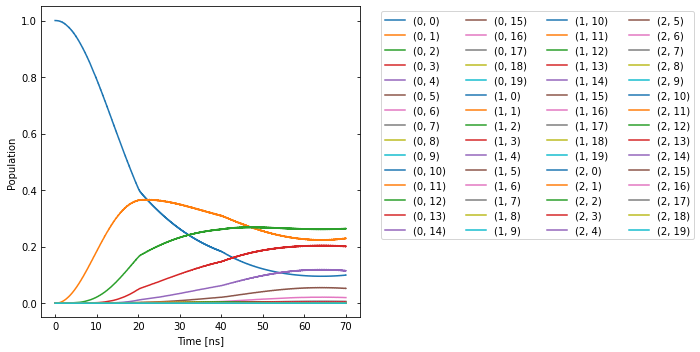

In [8]:
psi_init = [[0] * model.tot_dim]
init_state_index = model.get_state_indeces([(0,0)])[0]
psi_init[0][init_state_index] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
if model.lindbladian:
    init_state = tf_utils.tf_state_to_dm(init_state)
sequence = ['CLEAR[1]']
plotPopulation(exp=exp, psi_init=init_state, sequence=sequence, usePlotly=False)

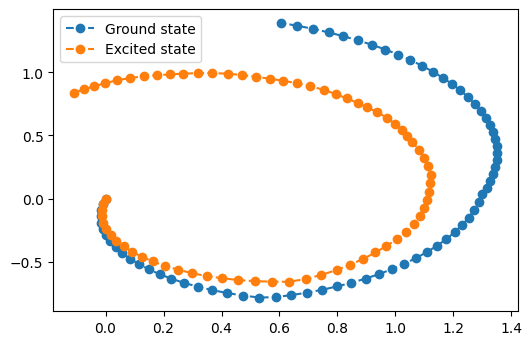

<Figure size 432x288 with 0 Axes>

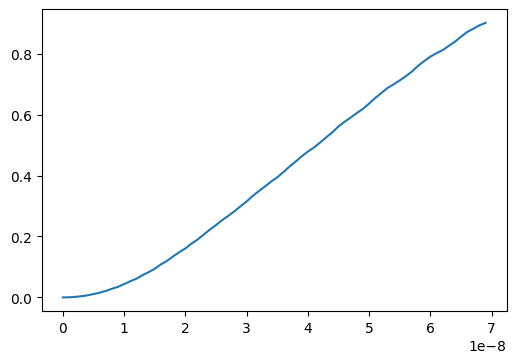

<Figure size 432x288 with 0 Axes>

In [9]:
plotIQ(exp, sequence, model.ann_opers[1], resonator_frequency, resonator_frequency, spacing=100, usePlotly=False)

In [14]:
parameter_map.set_opt_map([
    [("CLEAR[1]", "dR", "carrier", "freq")],
])


psi = [[0] * model.tot_dim]
ground_state_index = model.get_state_indeces([(0,0)])[0]
psi[0][ground_state_index] = 1
ground_state = tf.transpose(tf.constant(psi, tf.complex128))
if model.lindbladian:
    ground_state = tf_utils.tf_state_to_dm(ground_state)


psi = [[0] * model.tot_dim]
excited_state_index = model.get_state_indeces([(1,0)])[0]
psi[0][excited_state_index] = 1
excited_state = tf.transpose(tf.constant(psi, tf.complex128))
if model.lindbladian:
    excited_state = tf_utils.tf_state_to_dm(excited_state)


freq_drive = resonator_frequency

aR = tf.convert_to_tensor(model.ann_opers[1], dtype = tf.complex128)
aQ = tf.convert_to_tensor(model.ann_opers[0], dtype = tf.complex128)
aR_dag = tf.transpose(aR, conjugate=True)
NR = tf.matmul(aR_dag,aR)
aQ_dag = tf.transpose(aQ, conjugate=True)
NQ = tf.matmul(aQ_dag, aQ)

Urot = tf.linalg.expm(1j*2*np.pi*freq_drive*(NR + NQ)*t_total)
U_rot_dag = tf.transpose(Urot, conjugate=True)
a_rotated = tf.matmul(U_rot_dag, tf.matmul(aR, Urot))

d_max = 1.0

fid_params = {
    "ground_state": ground_state,
    "excited_state": excited_state,
    "a_rotated": a_rotated,
    "cutoff_distance": d_max,
    "lindbladian": model.lindbladian
}
#%%


opt = OptimalControl(
    dir_path="./output/",
    fid_func=fidelities.IQ_plane_distance,
    fid_subspace=["Q", "R"],
    pmap=parameter_map,
    algorithm=algorithms.lbfgs,
    options={"maxfun":250},
    run_name="CLEAR",
    fid_func_kwargs={"params":fid_params}
)
exp.set_opt_gates(["CLEAR[1]"])
opt.set_exp(exp)

In [ ]:
opt.optimize_controls()
print(opt.current_best_goal)
print(parameter_map.print_parameters())

In [ ]:
exp.write_config("Test_CLEAR.hjson")
parameter_map.store_values("Test_CLEAR_optimized_values_run1.c3log")

In [ ]:
opt.goal_run(parameter_map.get_parameters())

### SWAP with dissipation
Add 2nd drive channel

In [7]:
drive_qubit_1 = chip.Drive(
    name="dQ1",
    desc="Qubit Drive 1",
    comment="Drive line on qubit",
    connected=["Q"],
    hamiltonian_func=hamiltonians.x_drive
)

drive_qubit_2 = chip.Drive(
    name="dQ2",
    desc="Qubit Drive 2",
    comment="Drive line on qubit",
    connected=["Q"],
    hamiltonian_func=hamiltonians.x_drive
)


drive_resonator_1 = chip.Drive(
    name="dR1",
    desc="Resonator Drive 1",
    comment="Drive line on resonator",
    connected=["R"],
    hamiltonian_func=hamiltonians.x_drive
)

drive_resonator_2 = chip.Drive(
    name="dR2",
    desc="Resonator Drive 2",
    comment="Drive line on resonator",
    connected=["R"],
    hamiltonian_func=hamiltonians.x_drive
)



model = Mdl(
    [qubit, resonator], # Individual, self-contained components
    [drive_qubit_1, drive_qubit_2, drive_resonator_1, drive_resonator_2, qr_coupling]  # Interactions between components
)
model.set_lindbladian(False)
model.set_dressed(False)

generator = Gnr(
        devices={
            "LO": devices.LO(name='lo', resolution=sim_res, outputs=1),
            "AWG": devices.AWG(name='awg', resolution=awg_res, outputs=1),
            "DigitalToAnalog": devices.DigitalToAnalog(
                name="dac",
                resolution=sim_res,
                inputs=1,
                outputs=1
            ),
            "Response": devices.Response(
                name='resp',
                rise_time=Qty(
                    value=0.3e-9,
                    min_val=0.05e-9,
                    max_val=0.6e-9,
                    unit='s'
                ),
                resolution=sim_res,
                inputs=1,
                outputs=1
            ),
            "Mixer": devices.Mixer(name='mixer', inputs=2, outputs=1),
            "VoltsToHertz": devices.VoltsToHertz(
                name='v_to_hz',
                V_to_Hz=Qty(
                    value=1e9,
                    min_val=0.9e9,
                    max_val=1.1e9,
                    unit='Hz/V'
                ),
                inputs=1,
                outputs=1
            )
        },
        chains= {
            "dQ1":{
                "LO": [],
                "AWG": [],
                "DigitalToAnalog": ["AWG"],
                "Response": ["DigitalToAnalog"],
                "Mixer": ["LO", "Response"],
                "VoltsToHertz": ["Mixer"]
            },
            "dR1":{
                "LO": [],
                "AWG": [],
                "DigitalToAnalog": ["AWG"],
                "Response": ["DigitalToAnalog"],
                "Mixer": ["LO", "Response"],
                "VoltsToHertz": ["Mixer"]
            },
            "dQ2":{
                "LO": [],
                "AWG": [],
                "DigitalToAnalog": ["AWG"],
                "Response": ["DigitalToAnalog"],
                "Mixer": ["LO", "Response"],
                "VoltsToHertz": ["Mixer"]
            },
            "dR2":{
                "LO": [],
                "AWG": [],
                "DigitalToAnalog": ["AWG"],
                "Response": ["DigitalToAnalog"],
                "Mixer": ["LO", "Response"],
                "VoltsToHertz": ["Mixer"]
            }
        }

    )

generator.devices["AWG"].enable_drag_2()


In [34]:
from qutip import *
import numpy as np
Nq = 3
Nr = 3
Ideal_gate = np.array(tensor(qeye(Nq), qeye(Nr)) + tensor(basis(Nq,1),basis(Nr,0))*tensor(basis(Nq,0),basis(Nr,1)).dag() + tensor(basis(Nq,0),basis(Nr,1))*tensor(basis(Nq,1),basis(Nr,0)).dag() - tensor(basis(Nq,1),basis(Nr,0))*tensor(basis(Nq,1),basis(Nr,0)).dag() - tensor(basis(Nq,0),basis(Nr,1))*tensor(basis(Nq,0),basis(Nr,1)).dag()) 
print(Ideal_gate)
np.savetxt("ideal_gate.csv", Ideal_gate, delimiter=",")

t_swap_gate = 250e-9
sideband = 50e6

tswap_10_20 = 11e-9
tswap_20_01 = 220e-9


Qswap_params = {
    "amp": Qty(value=0.3,min_val=0.0,max_val=10.0,unit="V"),
    "t_up": Qty(value=2.0e-9, min_val=0.0, max_val=tswap_10_20, unit="s"),
    "t_down": Qty(value=tswap_10_20-2.0e-9, min_val=0.0, max_val=tswap_10_20, unit="s"),
    "risefall": Qty(value=1.0e-9, min_val=0.1e-9, max_val=tswap_10_20/2, unit="s"),
    "xy_angle": Qty(value=0.0,min_val=-0.5 * np.pi,max_val=2.5 * np.pi,unit="rad"),
    "freq_offset": Qty(value=-sideband - 3e6,min_val=-56 * 1e6,max_val=-52 * 1e6,unit="Hz 2pi"),
    "delta": Qty(value=-1,min_val=-5,max_val=3,unit=""),
    "t_final": Qty(value=t_swap_gate,min_val=0.1*t_swap_gate,max_val=1.5*t_swap_gate,unit="s")
}


Qswap2_params = {
    "amp": Qty(value=1.0,min_val=0.0,max_val=10.0,unit="V"),
    "t_up": Qty(value=t_swap_gate - tswap_20_01, min_val=0.0, max_val=tswap_20_01, unit="s"),
    "t_down": Qty(value=t_swap_gate-2.0e-9, min_val=0.0, max_val=t_swap_gate, unit="s"),
    "risefall": Qty(value=1.0e-9, min_val=0.1e-9, max_val=t_swap_gate/2, unit="s"),
    "xy_angle": Qty(value=0.0,min_val=-0.5 * np.pi,max_val=2.5 * np.pi,unit="rad"),
    "freq_offset": Qty(value=-sideband - 3e6,min_val=-56 * 1e6,max_val=-52 * 1e6,unit="Hz 2pi"),
    "delta": Qty(value=-1,min_val=-5,max_val=3,unit=""),
    "t_final": Qty(value=t_swap_gate,min_val=0.1*t_swap_gate,max_val=1.5*t_swap_gate,unit="s")
}

Qswap_pulse = pulse.Envelope(
    name="swap_pulse",
    desc="Flattop pluse for SWAP gate",
    params=Qswap_params,
    shape=envelopes.flattop
)

Qswap2_pulse = pulse.Envelope(
    name="swap2_pulse",
    desc="Flattop pluse for SWAP gate",
    params=Qswap2_params,
    shape=envelopes.flattop
)

Rswap_params = {
    "amp": Qty(value=0.3,min_val=0.0,max_val=10.0,unit="V"),
    "t_up": Qty(value=2.0e-9, min_val=0.0, max_val=tswap_10_20, unit="s"),
    "t_down": Qty(value=tswap_10_20-2.0e-9, min_val=0.0, max_val=tswap_10_20, unit="s"),
    "risefall": Qty(value=1.0e-9, min_val=0.1e-9, max_val=tswap_10_20/2, unit="s"),
    "xy_angle": Qty(value=0.0,min_val=-0.5 * np.pi,max_val=2.5 * np.pi,unit="rad"),
    "freq_offset": Qty(value=-sideband - 3e6,min_val=-56 * 1e6,max_val=-52 * 1e6,unit="Hz 2pi"),
    "delta": Qty(value=-1,min_val=-5,max_val=3,unit=""),
    "t_final": Qty(value=t_swap_gate,min_val=0.1*t_swap_gate,max_val=1.5*t_swap_gate,unit="s")
}


Rswap2_params = {
    "amp": Qty(value=1.0,min_val=0.0,max_val=10.0,unit="V"),
    "t_up": Qty(value=t_swap_gate - tswap_20_01, min_val=0.0, max_val=tswap_20_01, unit="s"),
    "t_down": Qty(value=t_swap_gate-2.0e-9, min_val=0.0, max_val=t_swap_gate, unit="s"),
    "risefall": Qty(value=1.0e-9, min_val=0.1e-9, max_val=t_swap_gate/2, unit="s"),
    "xy_angle": Qty(value=0.0,min_val=-0.5 * np.pi,max_val=2.5 * np.pi,unit="rad"),
    "freq_offset": Qty(value=-sideband - 3e6,min_val=-56 * 1e6,max_val=-52 * 1e6,unit="Hz 2pi"),
    "delta": Qty(value=-1,min_val=-5,max_val=3,unit=""),
    "t_final": Qty(value=t_swap_gate,min_val=0.1*t_swap_gate,max_val=1.5*t_swap_gate,unit="s")
}


Rswap_pulse = pulse.Envelope(
    name="swap_pulse",
    desc="Flattop pluse for SWAP gate",
    params=Rswap_params,
    shape=envelopes.flattop
)

Rswap2_pulse = pulse.Envelope(
    name="swap2_pulse",
    desc="Flattop pluse for SWAP gate",
    params=Rswap2_params,
    shape=envelopes.flattop
)


nodrive_pulse = pulse.Envelope(
    name="no_drive",
    params={
        "t_final": Qty(
            value=t_swap_gate,
            min_val=0.5 * t_swap_gate,
            max_val=1.5 * t_swap_gate,
            unit="s"
        )
    },
    shape=envelopes.no_drive
)


tlist = np.linspace(0,t_swap_gate, 1000)
#plotSignal(tlist, Qswap_pulse.shape(tlist, Qswap_pulse.params).numpy())
#plotSignal(tlist, Qswap2_pulse.shape(tlist, Qswap2_pulse.params).numpy())
#plotSignal(tlist, Rswap_pulse.shape(tlist, Rswap_pulse.params).numpy())
#plotSignal(tlist, Rswap2_pulse.shape(tlist, Rswap2_pulse.params).numpy())

#index = model.get_state_indeces([(1,0),(0,1)])
#state_energies = [model.eigenframe[i].numpy() for i in index]
#print(abs(state_energies[0] - state_energies[1])/(2*np.pi*1e9))


drive_freq_qubit = 7.65e9
drive_freq_resonator = 7.65e9
carrier_freq = [drive_freq_qubit, drive_freq_resonator]
carrier_parameters = {
            "Q":{"freq": Qty(value=carrier_freq[0], min_val=0.0, max_val=10e9, unit="Hz 2pi"),
            "framechange": Qty(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit="rad")},
            "R": {"freq": Qty(value=carrier_freq[1], min_val=0.0, max_val=10e9, unit="Hz 2pi"),
            "framechange": Qty(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit="rad")}
            }

carriers = [
    pulse.Carrier(name="carrier", desc="Frequency of the local oscillator", params=carrier_parameters["Q"]),
    pulse.Carrier(name="carrier", desc="Frequency of the local oscillator", params=carrier_parameters["R"])
]


drive_freq_qubit = 9.5095e9
drive_freq_resonator = 9.5095e9
carrier_freq = [drive_freq_qubit, drive_freq_resonator]
carrier_parameters = {
            "Q":{"freq": Qty(value=carrier_freq[0], min_val=0.0, max_val=10e9, unit="Hz 2pi"),
            "framechange": Qty(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit="rad")},
            "R": {"freq": Qty(value=carrier_freq[1], min_val=0.0, max_val=10e9, unit="Hz 2pi"),
            "framechange": Qty(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit="rad")}
            }

carriers_2 = [
    pulse.Carrier(name="carrier", desc="Frequency of the local oscillator", params=carrier_parameters["Q"]),
    pulse.Carrier(name="carrier", desc="Frequency of the local oscillator", params=carrier_parameters["R"])
]

ideal_gate = np.loadtxt("ideal_gate.csv", delimiter=",", dtype=np.complex128)

swap_gate = gates.Instruction(
    name="swap", targets=[0, 1], t_start=0.0, t_end=t_swap_gate, channels=["dQ1", "dR1", "dQ2", "dR2"], 
    ideal=ideal_gate
)

swap_gate.add_component(Qswap_pulse, "dQ1")
swap_gate.add_component(carriers[0], "dQ1")

swap_gate.add_component(Qswap2_pulse, "dQ2")
swap_gate.add_component(carriers_2[0], "dQ2")

swap_gate.add_component(Rswap_pulse, "dR1")
swap_gate.add_component(carriers[1], "dR1")

swap_gate.add_component(Rswap2_pulse, "dR2")
swap_gate.add_component(carriers_2[1], "dR2")


gates_arr = [swap_gate]

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]]


In [35]:
parameter_map = PMap(instructions=gates_arr, model=model, generator=generator)
#parameter_map.load_values("best_point.txt")
exp = Exp(pmap=parameter_map)
exp.set_opt_gates(['swap[0, 1]'])

model.set_FR(False)
model.set_lindbladian(False)
exp.propagate_batch_size = 20000

unitaries = exp.compute_propagators()

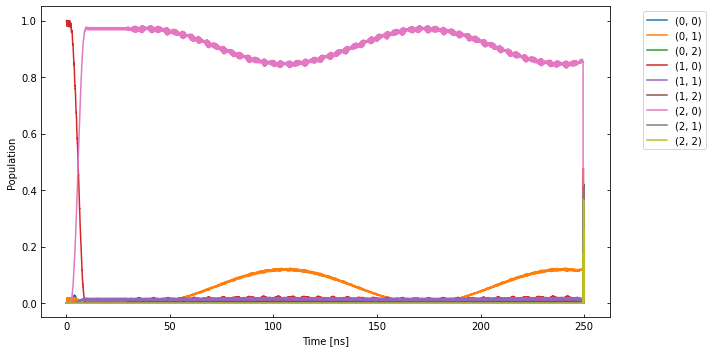

In [36]:
init_state_index = model.get_state_indeces([(1,0)])[0]
psi_init = [[0] * model.tot_dim]
psi_init[0][init_state_index] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
if model.lindbladian:
    init_state = tf_utils.tf_state_to_dm(init_state)
sequence = ['swap[0, 1]']
plotPopulation(exp=exp, psi_init=init_state, sequence=sequence, usePlotly=False)

In [37]:

opt_map = [
    [("swap[0, 1]", "dR1", "carrier", "freq")],
    [("swap[0, 1]", "dR1", "swap_pulse", "amp")],
    [("swap[0, 1]", "dR1", "swap_pulse", "t_up")],
    [("swap[0, 1]", "dR1", "swap_pulse", "t_down")],
    [("swap[0, 1]", "dR1", "swap_pulse", "risefall")],
    [("swap[0, 1]", "dR1", "swap_pulse", "xy_angle")],
    [("swap[0, 1]", "dR1", "swap_pulse", "freq_offset")],
    [("swap[0, 1]", "dR1", "swap_pulse", "delta")],
    [("swap[0, 1]", "dQ1", "carrier", "freq")],
    [("swap[0, 1]", "dQ1", "swap_pulse", "amp")],
    [("swap[0, 1]", "dQ1", "swap_pulse", "t_up")],
    [("swap[0, 1]", "dQ1", "swap_pulse", "t_down")],
    [("swap[0, 1]", "dQ1", "swap_pulse", "risefall")],
    [("swap[0, 1]", "dQ1", "swap_pulse", "xy_angle")],
    [("swap[0, 1]", "dQ1", "swap_pulse", "freq_offset")],
    [("swap[0, 1]", "dQ1", "swap_pulse", "delta")],
    [("swap[0, 1]", "dR2", "carrier", "freq")],
    [("swap[0, 1]", "dR2", "swap2_pulse", "amp")],
    [("swap[0, 1]", "dR2", "swap2_pulse", "t_up")],
    [("swap[0, 1]", "dR2", "swap2_pulse", "t_down")],
    [("swap[0, 1]", "dR2", "swap2_pulse", "risefall")],
    [("swap[0, 1]", "dR2", "swap2_pulse", "xy_angle")],
    [("swap[0, 1]", "dR2", "swap2_pulse", "freq_offset")],
    [("swap[0, 1]", "dR2", "swap2_pulse", "delta")],
    [("swap[0, 1]", "dQ2", "carrier", "freq")],
    [("swap[0, 1]", "dQ2", "swap2_pulse", "amp")],
    [("swap[0, 1]", "dQ2", "swap2_pulse", "t_up")],
    [("swap[0, 1]", "dQ2", "swap2_pulse", "t_down")],
    [("swap[0, 1]", "dQ2", "swap2_pulse", "risefall")],
    [("swap[0, 1]", "dQ2", "swap2_pulse", "xy_angle")],
    [("swap[0, 1]", "dQ2", "swap2_pulse", "freq_offset")],
    [("swap[0, 1]", "dQ2", "swap2_pulse", "delta")],
]


parameter_map.set_opt_map(opt_map)

opt = OptimalControl(
    dir_path="./output/",
    fid_func=fidelities.state_transfer_infid_set_full,
    fid_subspace=["Q", "R"],
    pmap=parameter_map,
    algorithm=algorithms.lbfgs,
    options={"maxfun":1000},
    run_name="SWAP_20_01_full",
    fid_func_kwargs={"psi_0":init_state}
)
exp.set_opt_gates(["swap[0, 1]"])
opt.set_exp(exp)

In [38]:
opt.optimize_controls()
print(opt.current_best_goal)
print(parameter_map.print_parameters())


C3:STATUS:Saving as: /home/ubuntu/Ashutosh_files/Qubit_readout/Ashutosh_codes/output/SWAP_20_01_full/2022_05_13_T_14_51_00/open_loop.c3log


## Junk code

Lets do a sweep over the frequencies of the drive and see if it we can see a reset at some point

In [ ]:
labels = list(map(str, model.state_labels))
x = np.array([[0]*10, [1]*10, [2]*10]).flatten()
y = model.eigenframe.numpy()
plt.scatter(x, y)

for i, txt in enumerate(labels):
    plt.annotate(txt, (x[i], y[i]))

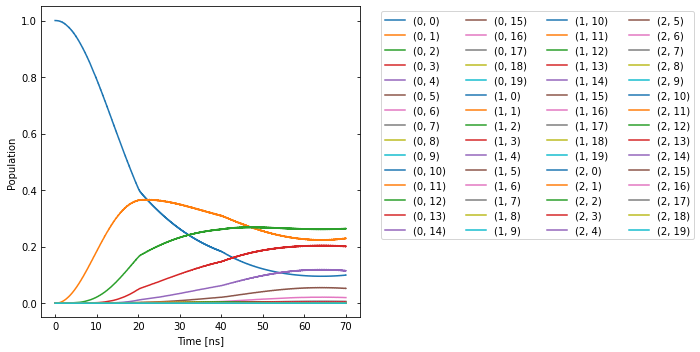

In [8]:
psi_init = [[0] * model.tot_dim]
init_state_index = model.get_state_indeces([(0,0)])[0]
psi_init[0][init_state_index] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
if model.lindbladian:
    init_state = tf_utils.tf_state_to_dm(init_state)
sequence = ['CLEAR[1]']
plotPopulation(exp=exp, psi_init=init_state, sequence=sequence, usePlotly=False)

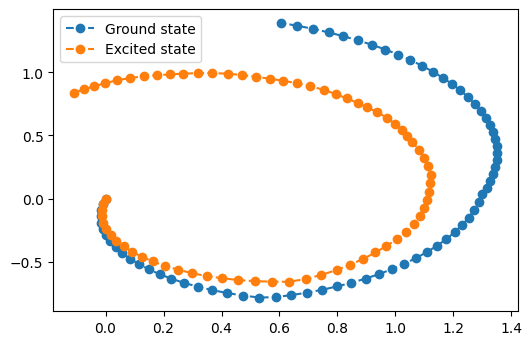

<Figure size 432x288 with 0 Axes>

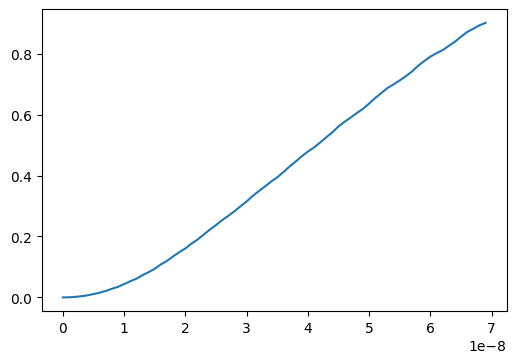

<Figure size 432x288 with 0 Axes>

In [9]:
plotIQ(exp, sequence, model.ann_opers[1], resonator_frequency, resonator_frequency, spacing=100, usePlotly=False)

In [14]:
parameter_map.set_opt_map([
    [("CLEAR[1]", "dR", "carrier", "freq")],
])


psi = [[0] * model.tot_dim]
ground_state_index = model.get_state_indeces([(0,0)])[0]
psi[0][ground_state_index] = 1
ground_state = tf.transpose(tf.constant(psi, tf.complex128))
if model.lindbladian:
    ground_state = tf_utils.tf_state_to_dm(ground_state)


psi = [[0] * model.tot_dim]
excited_state_index = model.get_state_indeces([(1,0)])[0]
psi[0][excited_state_index] = 1
excited_state = tf.transpose(tf.constant(psi, tf.complex128))
if model.lindbladian:
    excited_state = tf_utils.tf_state_to_dm(excited_state)


freq_drive = resonator_frequency

aR = tf.convert_to_tensor(model.ann_opers[1], dtype = tf.complex128)
aQ = tf.convert_to_tensor(model.ann_opers[0], dtype = tf.complex128)
aR_dag = tf.transpose(aR, conjugate=True)
NR = tf.matmul(aR_dag,aR)
aQ_dag = tf.transpose(aQ, conjugate=True)
NQ = tf.matmul(aQ_dag, aQ)

Urot = tf.linalg.expm(1j*2*np.pi*freq_drive*(NR + NQ)*t_total)
U_rot_dag = tf.transpose(Urot, conjugate=True)
a_rotated = tf.matmul(U_rot_dag, tf.matmul(aR, Urot))

d_max = 1.0

fid_params = {
    "ground_state": ground_state,
    "excited_state": excited_state,
    "a_rotated": a_rotated,
    "cutoff_distance": d_max,
    "lindbladian": model.lindbladian
}
#%%


opt = OptimalControl(
    dir_path="./output/",
    fid_func=fidelities.IQ_plane_distance,
    fid_subspace=["Q", "R"],
    pmap=parameter_map,
    algorithm=algorithms.lbfgs,
    options={"maxfun":250},
    run_name="CLEAR",
    fid_func_kwargs={"params":fid_params}
)
exp.set_opt_gates(["CLEAR[1]"])
opt.set_exp(exp)

In [ ]:
opt.optimize_controls()
print(opt.current_best_goal)
print(parameter_map.print_parameters())

In [ ]:
exp.write_config("Test_CLEAR.hjson")
parameter_map.store_values("Test_CLEAR_optimized_values_run1.c3log")

In [ ]:
opt.goal_run(parameter_map.get_parameters())

### SWAP with dissipation
Add 2nd drive channel

In [7]:
drive_qubit_1 = chip.Drive(
    name="dQ1",
    desc="Qubit Drive 1",
    comment="Drive line on qubit",
    connected=["Q"],
    hamiltonian_func=hamiltonians.x_drive
)

drive_qubit_2 = chip.Drive(
    name="dQ2",
    desc="Qubit Drive 2",
    comment="Drive line on qubit",
    connected=["Q"],
    hamiltonian_func=hamiltonians.x_drive
)


drive_resonator_1 = chip.Drive(
    name="dR1",
    desc="Resonator Drive 1",
    comment="Drive line on resonator",
    connected=["R"],
    hamiltonian_func=hamiltonians.x_drive
)

drive_resonator_2 = chip.Drive(
    name="dR2",
    desc="Resonator Drive 2",
    comment="Drive line on resonator",
    connected=["R"],
    hamiltonian_func=hamiltonians.x_drive
)



model = Mdl(
    [qubit, resonator], # Individual, self-contained components
    [drive_qubit_1, drive_qubit_2, drive_resonator_1, drive_resonator_2, qr_coupling]  # Interactions between components
)
model.set_lindbladian(False)
model.set_dressed(False)

generator = Gnr(
        devices={
            "LO": devices.LO(name='lo', resolution=sim_res, outputs=1),
            "AWG": devices.AWG(name='awg', resolution=awg_res, outputs=1),
            "DigitalToAnalog": devices.DigitalToAnalog(
                name="dac",
                resolution=sim_res,
                inputs=1,
                outputs=1
            ),
            "Response": devices.Response(
                name='resp',
                rise_time=Qty(
                    value=0.3e-9,
                    min_val=0.05e-9,
                    max_val=0.6e-9,
                    unit='s'
                ),
                resolution=sim_res,
                inputs=1,
                outputs=1
            ),
            "Mixer": devices.Mixer(name='mixer', inputs=2, outputs=1),
            "VoltsToHertz": devices.VoltsToHertz(
                name='v_to_hz',
                V_to_Hz=Qty(
                    value=1e9,
                    min_val=0.9e9,
                    max_val=1.1e9,
                    unit='Hz/V'
                ),
                inputs=1,
                outputs=1
            )
        },
        chains= {
            "dQ1":{
                "LO": [],
                "AWG": [],
                "DigitalToAnalog": ["AWG"],
                "Response": ["DigitalToAnalog"],
                "Mixer": ["LO", "Response"],
                "VoltsToHertz": ["Mixer"]
            },
            "dR1":{
                "LO": [],
                "AWG": [],
                "DigitalToAnalog": ["AWG"],
                "Response": ["DigitalToAnalog"],
                "Mixer": ["LO", "Response"],
                "VoltsToHertz": ["Mixer"]
            },
            "dQ2":{
                "LO": [],
                "AWG": [],
                "DigitalToAnalog": ["AWG"],
                "Response": ["DigitalToAnalog"],
                "Mixer": ["LO", "Response"],
                "VoltsToHertz": ["Mixer"]
            },
            "dR2":{
                "LO": [],
                "AWG": [],
                "DigitalToAnalog": ["AWG"],
                "Response": ["DigitalToAnalog"],
                "Mixer": ["LO", "Response"],
                "VoltsToHertz": ["Mixer"]
            }
        }

    )

generator.devices["AWG"].enable_drag_2()


[[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]]


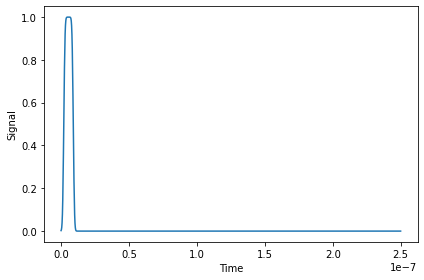

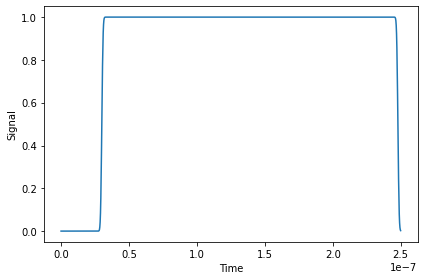

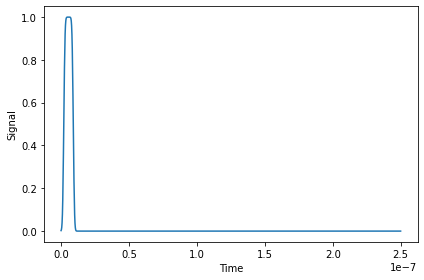

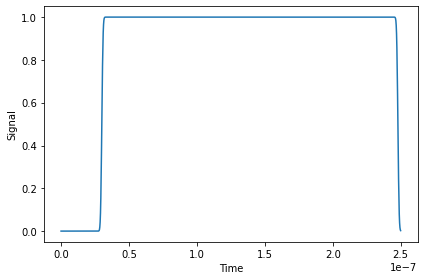

In [16]:
from qutip import *
import numpy as np
Nq = 3
Nr = 3
Ideal_gate = np.array(tensor(qeye(Nq), qeye(Nr)) + tensor(basis(Nq,1),basis(Nr,0))*tensor(basis(Nq,0),basis(Nr,1)).dag() + tensor(basis(Nq,0),basis(Nr,1))*tensor(basis(Nq,1),basis(Nr,0)).dag() - tensor(basis(Nq,1),basis(Nr,0))*tensor(basis(Nq,1),basis(Nr,0)).dag() - tensor(basis(Nq,0),basis(Nr,1))*tensor(basis(Nq,0),basis(Nr,1)).dag()) 
print(Ideal_gate)
np.savetxt("ideal_gate.csv", Ideal_gate, delimiter=",")

t_swap_gate = 250e-9
sideband = 50e6

tswap_10_20 = 11e-9
tswap_20_01 = 220e-9


Qswap_params = {
    "amp": Qty(value=0.3,min_val=0.0,max_val=10.0,unit="V"),
    "t_up": Qty(value=2.0e-9, min_val=0.0, max_val=tswap_10_20, unit="s"),
    "t_down": Qty(value=tswap_10_20-2.0e-9, min_val=0.0, max_val=tswap_10_20, unit="s"),
    "risefall": Qty(value=1.0e-9, min_val=0.1e-9, max_val=tswap_10_20/2, unit="s"),
    "xy_angle": Qty(value=0.0,min_val=-0.5 * np.pi,max_val=2.5 * np.pi,unit="rad"),
    "freq_offset": Qty(value=-sideband - 3e6,min_val=-56 * 1e6,max_val=-52 * 1e6,unit="Hz 2pi"),
    "delta": Qty(value=-1,min_val=-5,max_val=3,unit=""),
    "t_final": Qty(value=t_swap_gate,min_val=0.1*t_swap_gate,max_val=1.5*t_swap_gate,unit="s")
}


Qswap2_params = {
    "amp": Qty(value=1.0,min_val=0.0,max_val=10.0,unit="V"),
    "t_up": Qty(value=t_swap_gate - tswap_20_01, min_val=0.0, max_val=tswap_20_01, unit="s"),
    "t_down": Qty(value=t_swap_gate-2.0e-9, min_val=0.0, max_val=t_swap_gate, unit="s"),
    "risefall": Qty(value=1.0e-9, min_val=0.1e-9, max_val=t_swap_gate/2, unit="s"),
    "xy_angle": Qty(value=0.0,min_val=-0.5 * np.pi,max_val=2.5 * np.pi,unit="rad"),
    "freq_offset": Qty(value=-sideband - 3e6,min_val=-56 * 1e6,max_val=-52 * 1e6,unit="Hz 2pi"),
    "delta": Qty(value=-1,min_val=-5,max_val=3,unit=""),
    "t_final": Qty(value=t_swap_gate,min_val=0.1*t_swap_gate,max_val=1.5*t_swap_gate,unit="s")
}

Qswap_pulse = pulse.Envelope(
    name="swap_pulse",
    desc="Flattop pluse for SWAP gate",
    params=Qswap_params,
    shape=envelopes.flattop
)

Qswap2_pulse = pulse.Envelope(
    name="swap2_pulse",
    desc="Flattop pluse for SWAP gate",
    params=Qswap2_params,
    shape=envelopes.flattop
)

Rswap_params = {
    "amp": Qty(value=0.3,min_val=0.0,max_val=10.0,unit="V"),
    "t_up": Qty(value=2.0e-9, min_val=0.0, max_val=tswap_10_20, unit="s"),
    "t_down": Qty(value=tswap_10_20-2.0e-9, min_val=0.0, max_val=tswap_10_20, unit="s"),
    "risefall": Qty(value=1.0e-9, min_val=0.1e-9, max_val=tswap_10_20/2, unit="s"),
    "xy_angle": Qty(value=0.0,min_val=-0.5 * np.pi,max_val=2.5 * np.pi,unit="rad"),
    "freq_offset": Qty(value=-sideband - 3e6,min_val=-56 * 1e6,max_val=-52 * 1e6,unit="Hz 2pi"),
    "delta": Qty(value=-1,min_val=-5,max_val=3,unit=""),
    "t_final": Qty(value=t_swap_gate,min_val=0.1*t_swap_gate,max_val=1.5*t_swap_gate,unit="s")
}


Rswap2_params = {
    "amp": Qty(value=1.0,min_val=0.0,max_val=10.0,unit="V"),
    "t_up": Qty(value=t_swap_gate - tswap_20_01, min_val=0.0, max_val=tswap_20_01, unit="s"),
    "t_down": Qty(value=t_swap_gate-2.0e-9, min_val=0.0, max_val=t_swap_gate, unit="s"),
    "risefall": Qty(value=1.0e-9, min_val=0.1e-9, max_val=t_swap_gate/2, unit="s"),
    "xy_angle": Qty(value=0.0,min_val=-0.5 * np.pi,max_val=2.5 * np.pi,unit="rad"),
    "freq_offset": Qty(value=-sideband - 3e6,min_val=-56 * 1e6,max_val=-52 * 1e6,unit="Hz 2pi"),
    "delta": Qty(value=-1,min_val=-5,max_val=3,unit=""),
    "t_final": Qty(value=t_swap_gate,min_val=0.1*t_swap_gate,max_val=1.5*t_swap_gate,unit="s")
}


Rswap_pulse = pulse.Envelope(
    name="swap_pulse",
    desc="Flattop pluse for SWAP gate",
    params=Rswap_params,
    shape=envelopes.flattop
)

Rswap2_pulse = pulse.Envelope(
    name="swap2_pulse",
    desc="Flattop pluse for SWAP gate",
    params=Rswap2_params,
    shape=envelopes.flattop
)


nodrive_pulse = pulse.Envelope(
    name="no_drive",
    params={
        "t_final": Qty(
            value=t_swap_gate,
            min_val=0.5 * t_swap_gate,
            max_val=1.5 * t_swap_gate,
            unit="s"
        )
    },
    shape=envelopes.no_drive
)


tlist = np.linspace(0,t_swap_gate, 1000)
plotSignal(tlist, Qswap_pulse.shape(tlist, Qswap_pulse.params).numpy())
plotSignal(tlist, Qswap2_pulse.shape(tlist, Qswap2_pulse.params).numpy())

plotSignal(tlist, Rswap_pulse.shape(tlist, Rswap_pulse.params).numpy())
plotSignal(tlist, Rswap2_pulse.shape(tlist, Rswap2_pulse.params).numpy())

#index = model.get_state_indeces([(1,0),(0,1)])
#state_energies = [model.eigenframe[i].numpy() for i in index]
#print(abs(state_energies[0] - state_energies[1])/(2*np.pi*1e9))


drive_freq_qubit = 7.65e9
drive_freq_resonator = 7.65e9
carrier_freq = [drive_freq_qubit, drive_freq_resonator]
carrier_parameters = {
            "Q":{"freq": Qty(value=carrier_freq[0], min_val=0.0, max_val=10e9, unit="Hz 2pi"),
            "framechange": Qty(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit="rad")},
            "R": {"freq": Qty(value=carrier_freq[1], min_val=0.0, max_val=10e9, unit="Hz 2pi"),
            "framechange": Qty(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit="rad")}
            }

carriers = [
    pulse.Carrier(name="carrier", desc="Frequency of the local oscillator", params=carrier_parameters["Q"]),
    pulse.Carrier(name="carrier", desc="Frequency of the local oscillator", params=carrier_parameters["R"])
]


drive_freq_qubit = 9.5095e9
drive_freq_resonator = 9.5095e9
carrier_freq = [drive_freq_qubit, drive_freq_resonator]
carrier_parameters = {
            "Q":{"freq": Qty(value=carrier_freq[0], min_val=0.0, max_val=10e9, unit="Hz 2pi"),
            "framechange": Qty(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit="rad")},
            "R": {"freq": Qty(value=carrier_freq[1], min_val=0.0, max_val=10e9, unit="Hz 2pi"),
            "framechange": Qty(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit="rad")}
            }

carriers_2 = [
    pulse.Carrier(name="carrier", desc="Frequency of the local oscillator", params=carrier_parameters["Q"]),
    pulse.Carrier(name="carrier", desc="Frequency of the local oscillator", params=carrier_parameters["R"])
]

ideal_gate = np.loadtxt("ideal_gate.csv", delimiter=",", dtype=np.complex128)

swap_gate = gates.Instruction(
    name="swap", targets=[0, 1], t_start=0.0, t_end=t_swap_gate, channels=["dQ1", "dR1", "dQ2", "dR2"], 
    ideal=ideal_gate
)

swap_gate.add_component(Qswap_pulse, "dQ1")
swap_gate.add_component(carriers[0], "dQ1")

swap_gate.add_component(Qswap2_pulse, "dQ2")
swap_gate.add_component(carriers_2[0], "dQ2")

swap_gate.add_component(Rswap_pulse, "dR1")
swap_gate.add_component(carriers[1], "dR1")

swap_gate.add_component(Rswap2_pulse, "dR2")
swap_gate.add_component(carriers_2[1], "dR2")


gates_arr = [swap_gate]

In [17]:
parameter_map = PMap(instructions=gates_arr, model=model, generator=generator)
parameter_map.load_values()
exp = Exp(pmap=parameter_map)
exp.set_opt_gates(['swap[0, 1]'])

model.set_FR(False)
model.set_lindbladian(False)
exp.propagate_batch_size = 1000

unitaries = exp.compute_propagators()

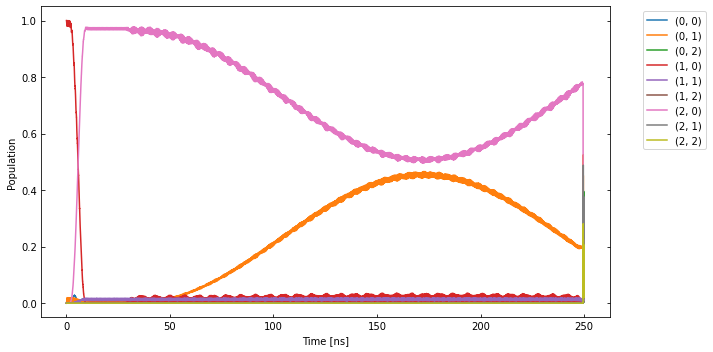

In [18]:
init_state_index = model.get_state_indeces([(1,0)])[0]
psi_init = [[0] * model.tot_dim]
psi_init[0][init_state_index] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
if model.lindbladian:
    init_state = tf_utils.tf_state_to_dm(init_state)
sequence = ['swap[0, 1]']
plotPopulation(exp=exp, psi_init=init_state, sequence=sequence, usePlotly=False)

## Junk code

Lets do a sweep over the frequencies of the drive and see if it we can see a reset at some point

In [ ]:
labels = list(map(str, model.state_labels))
x = np.array([[0]*10, [1]*10, [2]*10]).flatten()
y = model.eigenframe.numpy()
plt.scatter(x, y)

for i, txt in enumerate(labels):
    plt.annotate(txt, (x[i], y[i]))

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y/(2*np.pi*1e9), mode="markers+text", text=labels, textposition="top center"))
fig.update_layout(height=500, width=500)

In [ ]:
from qutip import *
import numpy as np
Nq = 3
Nr = 3
Ideal_gate = np.array(tensor(qeye(Nq), qeye(Nr)) + tensor(basis(Nq,2),basis(Nr,0))*tensor(basis(Nq,0),basis(Nr,1)).dag() + tensor(basis(Nq,0),basis(Nr,1))*tensor(basis(Nq,2),basis(Nr,0)).dag() - tensor(basis(Nq,2),basis(Nr,0))*tensor(basis(Nq,2),basis(Nr,0)).dag() - tensor(basis(Nq,0),basis(Nr,1))*tensor(basis(Nq,0),basis(Nr,1)).dag()) 
print(Ideal_gate)
np.savetxt("ideal_gate.csv", Ideal_gate, delimiter=",")

In [ ]:
M = np.loadtxt("ideal_gate.csv", delimiter=",", dtype=np.complex128)
print(M)

In [ ]:
S1 = 1e-3*np.array([222.709, 184.484, 385.353, 312.927, 385.534, 784.178, 910.896, 908.711, 817.750, 961.624, 926.969, 963.345, 832.831, 851.991, 763.276, 509.516, 28.116, 354.890, 234.149, 59.627])
S2 = 1e-3*np.array([53.001, 68.854, 358.599, 369.641, 765.301, 756.247, 706.647, 932.586, 914.490, 941.380, 714.821, 888.600, 955.149, 925.484, 519.482, 474.930, 225.622, 379.359, 126.467, 73.799]) 

In [ ]:
tlist = np.linspace(0,t_swap_gate, 20)
plotSignal(tlist,swap_gate_shape.numpy())

In [ ]:
plotSignal(tlist, S1)

In [ ]:
plotSignal(tlist, S2)

In [ ]:
## Piece-Wise constant pulse
tlist = np.linspace(0,t_swap_gate, 10)
swap_gate_shape = swap_pulse.shape(tlist, swap_pulse.params)

pwc_params = {
    "t_bin_start": Qty(value=0.0, min_val=0.0, max_val=1e-9, unit="s"),
    "t_bin_end": Qty(value=100e-9, min_val=50e-9, max_val=200e-9, unit="s"),
    "inphase": Qty(value=swap_gate_shape, min_val=0.0, max_val=1.0, unit="") 
}

pwc_swap_pulse = pulse.Envelope(
    name="swap_pulse",
    desc="Flattop pluse for SWAP gate",
    params=pwc_params,
    shape=envelopes.pwc_shape
)
tlist = np.linspace(0,t_swap_gate, 100)
plotSignal(tlist, pwc_swap_pulse.shape(tlist, pwc_swap_pulse.params).numpy())

# Gaussian PWC pulse
swap_params = {
    "amp": Qty(value=1.0,min_val=0.2,max_val=1.0,unit="V"),
    "t_final": Qty(value=t_swap_gate,min_val=100e-9,max_val=300e-9,unit="s"),
    "sigma": Qty(value=t_swap_gate/4, min_val=t_swap_gate/8, max_val=t_swap_gate/2, unit="s"),
    "xy_angle": Qty(value=0.0,min_val=-0.5 * np.pi,max_val=2.5 * np.pi,unit="rad"),
    "freq_offset": Qty(value=-sideband - 3e6,min_val=-56 * 1e6,max_val=-52 * 1e6,unit="Hz 2pi"),
    "delta": Qty(value=-1,min_val=-5,max_val=3,unit="")
}
swap_pulse = pulse.Envelope(
    name="swap_pulse",
    desc="Flattop pluse for SWAP gate",
    params=swap_params,
    shape=envelopes.gaussian_nonorm
)

tlist = np.linspace(0,t_swap_gate, 20)
swap_gate_shape = swap_pulse.shape(tlist, swap_pulse.params)

pwc_params = {
    "t_bin_start": Qty(value=0.0, min_val=0.0, max_val=1e-9, unit="s"),
    "t_bin_end": Qty(value=100e-9, min_val=50e-9, max_val=200e-9, unit="s"),
    "inphase": Qty(value=swap_gate_shape, min_val=0.0, max_val=1.0, unit="") 
}

pwc_swap_pulse = pulse.Envelope(
    name="swap_pulse_pwc",
    desc="Flattop pluse for SWAP gate",
    params=pwc_params,
    shape=envelopes.pwc_shape
)

tlist = np.linspace(0,t_swap_gate, 100)
plotSignal(tlist, pwc_swap_pulse.shape(tlist, pwc_swap_pulse.params).numpy())


In [ ]:

@fid_reg_deco
def state_transfer_infid_set_full(
    propagators: dict, instructions: dict, index, dims, psi_0, proj=True
):
    """
    Mean state transfer infidelity.

    Parameters
    ----------
    propagators : dict
        Contains unitary representations of the gates, identified by a key.
    index : int
        Index of the qubit(s) in the Hilbert space to be evaluated
    dims : list
        List of dimensions of qubits
    psi_0 : tf.Tensor
        Initial state of the device
    proj : boolean
        Project to computational subspace

    Returns
    -------
    tf.float
        State infidelity, averaged over the gates in propagators
    """
    infids = []
    for gate, propagator in propagators.items():
        perfect_gate = instructions[gate].get_ideal_gate(dims, full_hilbert_space=True)
        infid = state_transfer_infid_full(perfect_gate, propagator, index, dims, psi_0)
        infids.append(infid)
    return tf.reduce_mean(infids)


@fid_reg_deco
def state_transfer_infid_full(ideal: np.ndarray, actual: tf.constant, index, dims, psi_0):
    """
    Single gate state transfer infidelity. The dimensions of psi_0 and ideal need to be
    compatible and index and dims need to project actual to these same dimensions.

    Parameters
    ----------
    ideal: np.array
        Contains ideal unitary representations of the gate
    actual: tf.Tensor
        Contains actual unitary representations of the gate
    index : int
        Index of the qubit(s) in the Hilbert space to be evaluated
    dims : list
        List of dimensions of qubits
    psi_0: tf.Tensor
        Initial state

    Returns
    -------
    tf.float
        State infidelity for the selected gate

    """
    psi_ideal = tf.matmul(ideal, psi_0)
    psi_actual = tf.matmul(actual, psi_0)
    overlap = tf_ketket_fid(psi_ideal, psi_actual)
    infid = 1 - overlap
    return infid



In [ ]:

tswap = 50e-9

exp = Exp()
exp.read_config("qubit_reset_experiment_short.hjson")
pmap = exp.pmap
model = pmap.model
pmap.load_values("current_vals_short.c3log")
ts = np.linspace(0, tswap, 100)

pmap_dict = pmap.asdict()
Q_pulse = pmap_dict["swap[0, 1]"]["drive_channels"]["dQ"]["swap_pulse"]
R_pulse = pmap_dict["swap[0, 1]"]["drive_channels"]["dR"]["swap_pulse"]

Qpulse_carrier = pmap_dict["swap[0, 1]"]["drive_channels"]["dQ"]["carrier"]
Rpulse_carrier = pmap_dict["swap[0, 1]"]["drive_channels"]["dR"]["carrier"]

Qpulse_shape = Q_pulse.shape(ts, Q_pulse.params)
Rpulse_shape = R_pulse.shape(ts, R_pulse.params)

Qpulse_pwc_params = {
    "t_bin_start": Qty(value=0.0, min_val=0.0, max_val=1e-9, unit="s"),
    "t_bin_end": Qty(value=tswap, min_val=10e-9, max_val=200e-9, unit="s"),
    "inphase": Qty(value=Qpulse_shape, min_val=0.0, max_val=1.0, unit=""),
    "t_final": Qty(value=tswap, min_val=10e-9, max_val=300e-9, unit="s")
}


Qpwc_swap_pulse = pulse.Envelope(
    name="swap_pulse",
    desc="PWC pulse for Qubit",
    params=Qpulse_pwc_params,
    shape=envelopes.pwc_shape
)

Rpulse_pwc_params = {
    "t_bin_start": Qty(value=0.0, min_val=0.0, max_val=1e-9, unit="s"),
    "t_bin_end": Qty(value=tswap, min_val=10e-9, max_val=200e-9, unit="s"),
    "inphase": Qty(value=Rpulse_shape, min_val=0.0, max_val=1.0, unit=""),
    "t_final": Qty(value=tswap, min_val=10e-9, max_val=300e-9, unit="s") 
}


Rpwc_swap_pulse = pulse.Envelope(
    name="swap_pulse",
    desc="PWC pulse for resonator",
    params=Rpulse_pwc_params,
    shape=envelopes.pwc_shape
)

ideal_gate = pmap_dict["swap[0, 1]"]["ideal"]

#%%

swap_gate = gates.Instruction(
    name="swap", targets=[0, 1], t_start=0.0, t_end=tswap, channels=["dQ", "dR"], 
    ideal=ideal_gate
)
swap_gate.add_component(Qpwc_swap_pulse, "dQ")
swap_gate.add_component(Qpulse_carrier, "dQ")
swap_gate.add_component(Rpwc_swap_pulse, "dR")
swap_gate.add_component(Rpulse_carrier, "dR")

gates_arr = [swap_gate]

generator = pmap.generator
pmap = PMap(instructions=gates_arr, model=model, generator=generator)
exp = Exp(pmap=pmap)


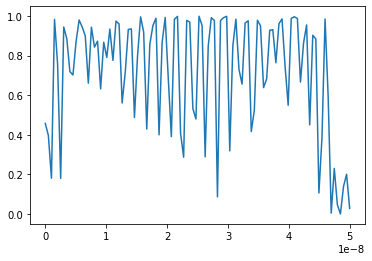

In [4]:
tswap = 50e-9

exp = Exp()
exp.read_config("qubit_reset_experiment_short_pwc.hjson")
pmap = exp.pmap
model = pmap.model
pmap.load_values("current_vals_short_pwc.c3log")
ts = np.linspace(0, tswap, 100)

pmap_dict = pmap.asdict()
Q_pulse = pmap_dict["swap[0, 1]"]["drive_channels"]["dQ"]["swap_pulse"]
R_pulse = pmap_dict["swap[0, 1]"]["drive_channels"]["dR"]["swap_pulse"]

Qpulse_carrier = pmap_dict["swap[0, 1]"]["drive_channels"]["dQ"]["carrier"]
Rpulse_carrier = pmap_dict["swap[0, 1]"]["drive_channels"]["dR"]["carrier"]

Qpulse_shape = Q_pulse.shape(ts, Q_pulse.params)
Rpulse_shape = R_pulse.shape(ts, R_pulse.params)

plt.plot(ts, Qpulse_shape)

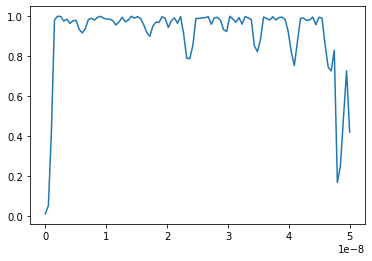

In [5]:
plt.plot(ts, Rpulse_shape)


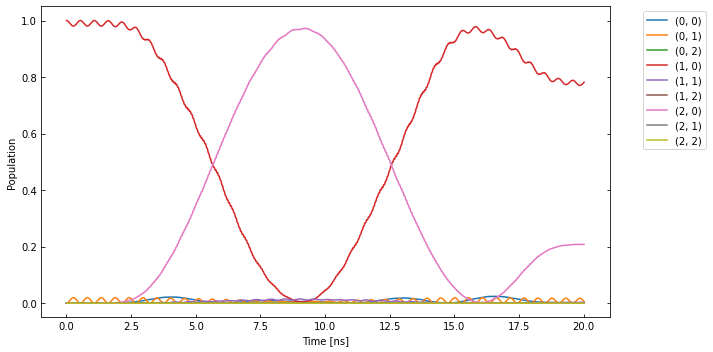

In [33]:
t_swap_gate = 20e-9
sideband = 50e6

Qswap_params = {
    "amp": Qty(value=0.3,min_val=0.0,max_val=10.0,unit="V"),
    "t_up": Qty(value=2.0e-9, min_val=0.0, max_val=t_swap_gate, unit="s"),
    "t_down": Qty(value=t_swap_gate-2.0e-9, min_val=0.0, max_val=t_swap_gate, unit="s"),
    "risefall": Qty(value=1.0e-9, min_val=0.1e-9, max_val=t_swap_gate/2, unit="s"),
    "xy_angle": Qty(value=0.0,min_val=-0.5 * np.pi,max_val=2.5 * np.pi,unit="rad"),
    "freq_offset": Qty(value=-sideband - 3e6,min_val=-56 * 1e6,max_val=-52 * 1e6,unit="Hz 2pi"),
    "delta": Qty(value=-1,min_val=-5,max_val=3,unit=""),
    "t_final": Qty(value=t_swap_gate,min_val=0.1*t_swap_gate,max_val=1.5*t_swap_gate,unit="s")
}

Qswap_pulse = pulse.Envelope(
    name="swap_pulse",
    desc="Flattop pluse for SWAP gate",
    params=Qswap_params,
    shape=envelopes.flattop
)

Rswap_params = {
    "amp": Qty(value=0.3,min_val=0.0,max_val=10.0,unit="V"),
    "t_up": Qty(value=2.0e-9, min_val=0.0, max_val=t_swap_gate, unit="s"),
    "t_down": Qty(value=t_swap_gate-2.0e-9, min_val=0.0, max_val=t_swap_gate, unit="s"),
    "risefall": Qty(value=1.0e-9, min_val=0.1e-9, max_val=t_swap_gate/2, unit="s"),
    "xy_angle": Qty(value=0.0,min_val=-0.5 * np.pi,max_val=2.5 * np.pi,unit="rad"),
    "freq_offset": Qty(value=-sideband - 3e6,min_val=-56 * 1e6,max_val=-52 * 1e6,unit="Hz 2pi"),
    "delta": Qty(value=-1,min_val=-5,max_val=3,unit=""),
    "t_final": Qty(value=t_swap_gate,min_val=0.1*t_swap_gate,max_val=1.5*t_swap_gate,unit="s")
}


Rswap_pulse = pulse.Envelope(
    name="swap_pulse",
    desc="Flattop pluse for SWAP gate",
    params=Rswap_params,
    shape=envelopes.flattop
)


nodrive_pulse = pulse.Envelope(
    name="no_drive",
    params={
        "t_final": Qty(
            value=t_swap_gate,
            min_val=0.5 * t_swap_gate,
            max_val=1.5 * t_swap_gate,
            unit="s"
        )
    },
    shape=envelopes.no_drive
)


drive_freq_qubit = 7.65e9
drive_freq_resonator = 7.65e9
carrier_freq = [drive_freq_qubit, drive_freq_resonator]
carrier_parameters = {
            "Q":{"freq": Qty(value=carrier_freq[0], min_val=0.0, max_val=10e9, unit="Hz 2pi"),
            "framechange": Qty(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit="rad")},
            "R": {"freq": Qty(value=carrier_freq[1], min_val=0.0, max_val=10e9, unit="Hz 2pi"),
            "framechange": Qty(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit="rad")}
            }

carriers = [
    pulse.Carrier(name="carrier", desc="Frequency of the local oscillator", params=carrier_parameters["Q"]),
    pulse.Carrier(name="carrier", desc="Frequency of the local oscillator", params=carrier_parameters["R"])
]


ideal_gate = np.loadtxt("ideal_gate.csv", delimiter=",", dtype=np.complex128)

swap_gate = gates.Instruction(
    name="swap", targets=[0, 1], t_start=0.0, t_end=t_swap_gate, channels=["dQ", "dR"], 
    ideal=ideal_gate
)

swap_gate.add_component(Qswap_pulse, "dQ")
swap_gate.add_component(copy.deepcopy(carriers[0]), "dQ")

swap_gate.add_component(Rswap_pulse, "dR")
swap_gate.add_component(copy.deepcopy(carriers[1]), "dR")

gates_arr = [swap_gate]


parameter_map = PMap(instructions=gates_arr, model=model, generator=generator)
exp = Exp(pmap=parameter_map)
exp.set_opt_gates(['swap[0, 1]'])
unitaries = exp.compute_propagators()
#plotComplexMatrix(unitaries['swap[0, 1]'].numpy())

init_state_index = model.get_state_indeces([(1,0)])[0]
psi_init = [[0] * model.tot_dim]
psi_init[0][init_state_index] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
sequence = ['swap[0, 1]']
plotPopulation(exp=exp, psi_init=init_state, sequence=sequence, usePlotly=False)

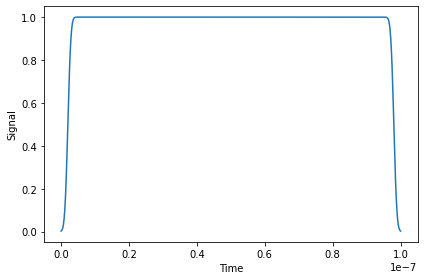

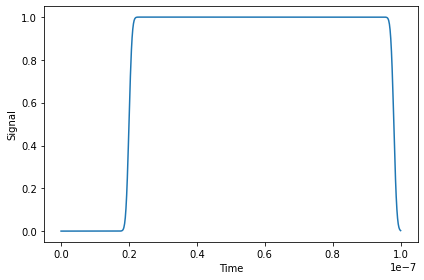

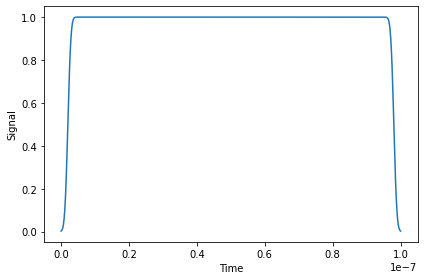

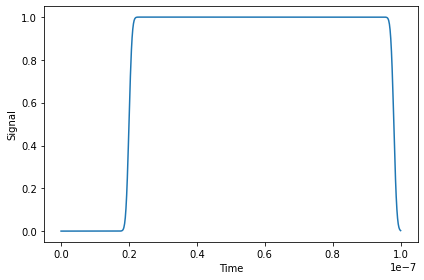

"\nparameter_map = PMap(instructions=gates_arr, model=model, generator=generator)\nexp = Exp(pmap=parameter_map)\nexp.set_opt_gates(['swap[0, 1]'])\nunitaries = exp.compute_propagators()\n#plotComplexMatrix(unitaries['swap[0, 1]'].numpy())\n\ninit_state_index = model.get_state_indeces([(1,0)])[0]\npsi_init = [[0] * model.tot_dim]\npsi_init[0][init_state_index] = 1\ninit_state = tf.transpose(tf.constant(psi_init, tf.complex128))\nsequence = ['swap[0, 1]']\nplotPopulation(exp=exp, psi_init=init_state, sequence=sequence, usePlotly=False)"

In [57]:
t_swap_gate = 100e-9
sideband = 50e6

tswap_10_20 = 9e-9
tswap_20_01 = 80e-9


Qswap_params = {
    "amp": Qty(value=0.3,min_val=0.0,max_val=10.0,unit="V"),
    "t_up": Qty(value=2.0e-9, min_val=0.0, max_val=t_swap_gate, unit="s"),
    "t_down": Qty(value=t_swap_gate-2.0e-9, min_val=0.0, max_val=t_swap_gate, unit="s"),
    "risefall": Qty(value=1.0e-9, min_val=0.1e-9, max_val=t_swap_gate/2, unit="s"),
    "xy_angle": Qty(value=0.0,min_val=-0.5 * np.pi,max_val=2.5 * np.pi,unit="rad"),
    "freq_offset": Qty(value=-sideband - 3e6,min_val=-56 * 1e6,max_val=-52 * 1e6,unit="Hz 2pi"),
    "delta": Qty(value=-1,min_val=-5,max_val=3,unit=""),
    "t_final": Qty(value=t_swap_gate,min_val=0.1*t_swap_gate,max_val=1.5*t_swap_gate,unit="s")
}

Qswap2_params = {
    "amp": Qty(value=1.0,min_val=0.0,max_val=10.0,unit="V"),
    "t_up": Qty(value=t_swap_gate - tswap_20_01, min_val=0.0, max_val=tswap_20_01, unit="s"),
    "t_down": Qty(value=t_swap_gate-2.0e-9, min_val=0.0, max_val=t_swap_gate, unit="s"),
    "risefall": Qty(value=1.0e-9, min_val=0.1e-9, max_val=t_swap_gate/2, unit="s"),
    "xy_angle": Qty(value=0.0,min_val=-0.5 * np.pi,max_val=2.5 * np.pi,unit="rad"),
    "freq_offset": Qty(value=-sideband - 3e6,min_val=-76 * 1e6,max_val=-52 * 1e6,unit="Hz 2pi"),
    "delta": Qty(value=-1,min_val=-5,max_val=3,unit=""),
    "t_final": Qty(value=t_swap_gate,min_val=0.1*t_swap_gate,max_val=1.5*t_swap_gate,unit="s")
}

Qswap_pulse = pulse.Envelope(
    name="swap_pulse",
    desc="Flattop pluse for SWAP gate",
    params=Qswap_params,
    shape=envelopes.flattop
)

Qswap2_pulse = pulse.Envelope(
    name="2nd_swap_pulse",
    desc="Flattop pluse for SWAP gate",
    params=Qswap2_params,
    shape=envelopes.flattop
)

Rswap_params = {
    "amp": Qty(value=0.3,min_val=0.0,max_val=10.0,unit="V"),
    "t_up": Qty(value=2.0e-9, min_val=0.0, max_val=t_swap_gate, unit="s"),
    "t_down": Qty(value=t_swap_gate-2.0e-9, min_val=0.0, max_val=t_swap_gate, unit="s"),
    "risefall": Qty(value=1.0e-9, min_val=0.1e-9, max_val=t_swap_gate/2, unit="s"),
    "xy_angle": Qty(value=0.0,min_val=-0.5 * np.pi,max_val=2.5 * np.pi,unit="rad"),
    "freq_offset": Qty(value=-sideband - 3e6,min_val=-56 * 1e6,max_val=-52 * 1e6,unit="Hz 2pi"),
    "delta": Qty(value=-1,min_val=-5,max_val=3,unit=""),
    "t_final": Qty(value=t_swap_gate,min_val=0.1*t_swap_gate,max_val=1.5*t_swap_gate,unit="s")
}



Rswap2_params = {
    "amp": Qty(value=1.0,min_val=0.0,max_val=10.0,unit="V"),
    "t_up": Qty(value=t_swap_gate - tswap_20_01, min_val=0.0, max_val=tswap_20_01, unit="s"),
    "t_down": Qty(value=t_swap_gate-2.0e-9, min_val=0.0, max_val=t_swap_gate, unit="s"),
    "risefall": Qty(value=1.0e-9, min_val=0.1e-9, max_val=t_swap_gate/2, unit="s"),
    "xy_angle": Qty(value=0.0,min_val=-0.5 * np.pi,max_val=2.5 * np.pi,unit="rad"),
    "freq_offset": Qty(value=-sideband - 3e6,min_val=-76 * 1e6,max_val=-52 * 1e6,unit="Hz 2pi"),
    "delta": Qty(value=-1,min_val=-5,max_val=3,unit=""),
    "t_final": Qty(value=t_swap_gate,min_val=0.1*t_swap_gate,max_val=1.5*t_swap_gate,unit="s")
}


Rswap_pulse = pulse.Envelope(
    name="swap_pulse",
    desc="Flattop pluse for SWAP gate",
    params=Rswap_params,
    shape=envelopes.flattop
)

Rswap2_pulse = pulse.Envelope(
    name="2nd_swap_pulse",
    desc="Flattop pluse for SWAP gate",
    params=Rswap2_params,
    shape=envelopes.flattop
)


nodrive_pulse = pulse.Envelope(
    name="no_drive",
    params={
        "t_final": Qty(
            value=t_swap_gate,
            min_val=0.5 * t_swap_gate,
            max_val=1.5 * t_swap_gate,
            unit="s"
        )
    },
    shape=envelopes.no_drive
)


tlist = np.linspace(0,t_swap_gate, 1000)
plotSignal(tlist, Qswap_pulse.shape(tlist, Qswap_pulse.params).numpy())
plotSignal(tlist, Qswap2_pulse.shape(tlist, Qswap2_pulse.params).numpy())

plotSignal(tlist, Rswap_pulse.shape(tlist, Rswap_pulse.params).numpy())
plotSignal(tlist, Rswap2_pulse.shape(tlist, Rswap2_pulse.params).numpy())

#index = model.get_state_indeces([(1,0),(0,1)])
#state_energies = [model.eigenframe[i].numpy() for i in index]
#print(abs(state_energies[0] - state_energies[1])/(2*np.pi*1e9))


drive_freq_qubit = 7.65e9
drive_freq_resonator = 7.65e9
carrier_freq = [drive_freq_qubit, drive_freq_resonator]
carrier_parameters = {
            "Q":{"freq": Qty(value=carrier_freq[0], min_val=0.0, max_val=10e9, unit="Hz 2pi"),
            "framechange": Qty(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit="rad")},
            "R": {"freq": Qty(value=carrier_freq[1], min_val=0.0, max_val=10e9, unit="Hz 2pi"),
            "framechange": Qty(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit="rad")}
            }

carriers = [
    pulse.Carrier(name="carrier", desc="Frequency of the local oscillator", params=carrier_parameters["Q"]),
    pulse.Carrier(name="carrier", desc="Frequency of the local oscillator", params=carrier_parameters["R"])
]


drive_freq_qubit = 9.5095e9
drive_freq_resonator = 9.5095e9
carrier_freq = [drive_freq_qubit, drive_freq_resonator]
carrier_parameters = {
            "Q":{"freq": Qty(value=carrier_freq[0], min_val=0.0, max_val=10e9, unit="Hz 2pi"),
            "framechange": Qty(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit="rad")},
            "R": {"freq": Qty(value=carrier_freq[1], min_val=0.0, max_val=10e9, unit="Hz 2pi"),
            "framechange": Qty(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit="rad")}
            }

carriers_2 = [
    pulse.Carrier(name="carrier2", desc="Frequency of the local oscillator", params=carrier_parameters["Q"]),
    pulse.Carrier(name="carrier2", desc="Frequency of the local oscillator", params=carrier_parameters["R"])
]

ideal_gate = np.loadtxt("ideal_gate.csv", delimiter=",", dtype=np.complex128)

swap_gate = gates.Instruction(
    name="swap", targets=[0, 1], t_start=0.0, t_end=t_swap_gate, channels=["dQ", "dR"], 
    ideal=ideal_gate
)

swap_gate.add_component(Qswap_pulse, "dQ")
swap_gate.add_component(copy.deepcopy(carriers[0]), "dQ")

swap_gate.add_component(Qswap2_pulse, "dQ")
swap_gate.add_component(copy.deepcopy(carriers_2[0]), "dQ")

swap_gate.add_component(Rswap_pulse, "dR")
swap_gate.add_component(copy.deepcopy(carriers[1]), "dR")

swap_gate.add_component(Rswap2_pulse, "dR")
swap_gate.add_component(copy.deepcopy(carriers_2[1]), "dR")


gates_arr = [swap_gate]

"""
parameter_map = PMap(instructions=gates_arr, model=model, generator=generator)
exp = Exp(pmap=parameter_map)
exp.set_opt_gates(['swap[0, 1]'])
unitaries = exp.compute_propagators()
#plotComplexMatrix(unitaries['swap[0, 1]'].numpy())

init_state_index = model.get_state_indeces([(1,0)])[0]
psi_init = [[0] * model.tot_dim]
psi_init[0][init_state_index] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
sequence = ['swap[0, 1]']
plotPopulation(exp=exp, psi_init=init_state, sequence=sequence, usePlotly=False)"""

In [60]:
pprint.pprint(swap_gate.comps)

{'dQ': {'2nd_swap_pulse': 2nd_swap_pulse:: amp : 1000.000 mV , delta : -1.000  , freq_offset : -53.000 MHz 2pi , xy_angle : -444.089 arad , sigma : 5.000 ns , t_final : 100.000 ns , t_up : 20.000 ns , t_down : 98.000 ns , risefall : 1.000 ns , shape: flattop, drag pulseFalse, ,
        'carrier': carrier:: freq : 7.650 GHz 2pi , framechange : 0.000 rad , ,
        'carrier2': carrier2:: freq : 9.510 GHz 2pi , framechange : 0.000 rad , ,
        'swap_pulse': swap_pulse:: amp : 300.000 mV , delta : -1.000  , freq_offset : -53.000 MHz 2pi , xy_angle : -444.089 arad , sigma : 5.000 ns , t_final : 100.000 ns , t_up : 2.000 ns , t_down : 98.000 ns , risefall : 1.000 ns , shape: flattop, drag pulseFalse, },
 'dR': {'2nd_swap_pulse': 2nd_swap_pulse:: amp : 1000.000 mV , delta : -1.000  , freq_offset : -53.000 MHz 2pi , xy_angle : -444.089 arad , sigma : 5.000 ns , t_final : 100.000 ns , t_up : 20.000 ns , t_down : 98.000 ns , risefall : 1.000 ns , shape: flattop, drag pulseFalse, ,
        'c

In [59]:
import pprint

In [15]:
def swap_and_readout(
    propagators: dict, instructions: dict, index, dims, params, n_eval=-1
):
    infids = []
    psi_g = params["ground_state"]
    psi_e = params["excited_state"]
    a_rotated = params["a_rotated"]
    d_max = params["cutoff_distance"]
    psi_0 = params["psi_0"]
    swap_cost = params["swap_cost"]
    lindbladian = params["lindbladian"]

    if lindbladian:
        psi_g = tf_utils.tf_dm_to_vec(psi_g)
        psi_e = tf_utils.tf_dm_to_vec(psi_e)

    for gate, propagator in propagators.items():
        psi_g_t = tf.matmul(propagator, psi_g)
        psi_e_t = tf.matmul(propagator, psi_e)

        if lindbladian:
            psi_g_t = tf_utils.tf_vec_to_dm(psi_g_t)
            psi_e_t = tf_utils.tf_vec_to_dm(psi_e_t)
            alpha0 = tf.linalg.trace(tf.matmul(psi_g_t, a_rotated))
            alpha1 = tf.linalg.trace(tf.matmul(psi_e_t, a_rotated))
        else:
            alpha0 = tf.matmul(
                tf.matmul(tf.transpose(psi_g_t, conjugate=True), a_rotated), psi_g_t
            )[0, 0]
            alpha1 = tf.matmul(
                tf.matmul(tf.transpose(psi_e_t, conjugate=True), a_rotated), psi_e_t
            )[0, 0]
        
        distance = tf.abs(alpha0 - alpha1)
        iq_infid = tf.exp(-distance / d_max)

        # calculate infidelity for swap
        ideal_swap_gate = instructions[gate].get_ideal_gate(
            dims, full_hilbert_space=True
        )
        psi_swap_ideal = tf.matmul(ideal_swap_gate, psi_0)
        psi_swap_actual = tf.matmul(propagator, psi_0)
        overlap = tf_utils.tf_ketket_fid(psi_swap_ideal, psi_swap_actual)
        swap_infid = 1 - overlap

        infid = iq_infid + swap_cost * swap_infid
        infids.append(infid)

    return tf.reduce_mean(infids)

In [17]:
propagators = unitaries
instructions = parameter_map.instructions
index = [0, 1]
dims = (3, 3)

psi = [[0] * model.tot_dim]
ground_state_index = model.get_state_indeces([(0,0)])[0]
psi[0][ground_state_index] = 1
ground_state = tf.transpose(tf.constant(psi, tf.complex128))
if model.lindbladian:
    ground_state = tf_utils.tf_state_to_dm(ground_state)


psi = [[0] * model.tot_dim]
excited_state_index = model.get_state_indeces([(1,0)])[0]
psi[0][excited_state_index] = 1
excited_state = tf.transpose(tf.constant(psi, tf.complex128))
if model.lindbladian:
    excited_state = tf_utils.tf_state_to_dm(excited_state)


freq_drive = resonator_frequency

aR = tf.convert_to_tensor(model.ann_opers[1], dtype = tf.complex128)
aQ = tf.convert_to_tensor(model.ann_opers[0], dtype = tf.complex128)
aR_dag = tf.transpose(aR, conjugate=True)
NR = tf.matmul(aR_dag,aR)
aQ_dag = tf.transpose(aQ, conjugate=True)
NQ = tf.matmul(aQ_dag, aQ)

Urot = tf.linalg.expm(1j*2*np.pi*freq_drive*(NR + NQ)*t_total)
U_rot_dag = tf.transpose(Urot, conjugate=True)
a_rotated = tf.matmul(U_rot_dag, tf.matmul(aR, Urot))

d_max = 1.0

swap_cost = 10.0

psi_0 = excited_state

fid_params = {
    "ground_state": ground_state,
    "excited_state": excited_state,
    "a_rotated": a_rotated,
    "cutoff_distance": d_max,
    "psi_0": psi_0,
    "swap_cost": swap_cost,
    "lindbladian": model.lindbladian
}


swap_and_readout(unitaries, instructions, index, dims, fid_params)


InvalidArgumentError: Matrix size-incompatible: In[0]: [1,1], In[1]: [9,9] [Op:MatMul]

In [ ]:

def swap_and_readout(
    propagators: dict, instructions: dict, index, dims, params, n_eval=-1
):
    infids = []
    psi_g = params["ground_state"]
    psi_e = params["excited_state"]
    a_rotated = params["a_rotated"]
    d_max = params["cutoff_distance"]
    psi_0 = params["psi_0"]
    swap_cost = params["swap_cost"]
    lindbladian = params["lindbladian"]
    
    swap_cost = tf.constant(swap_cost, dtype=tf.complex128)


    if lindbladian:
        psi_g = tf_utils.tf_dm_to_vec(psi_g)
        psi_e = tf_utils.tf_dm_to_vec(psi_e)
        psi_0 = tf_utils.tf_dm_to_vec(psi_0)


    for gate, propagator in propagators.items():
        print(gate)
        if gate == "Readout[1]":
            psi_g_t = tf.matmul(propagator, psi_g)
            psi_e_t = tf.matmul(propagator, psi_e)

            if lindbladian:
                psi_g_t = tf_utils.tf_vec_to_dm(psi_g_t)
                psi_e_t = tf_utils.tf_vec_to_dm(psi_e_t)
                alpha0 = tf.linalg.trace(tf.matmul(psi_g_t, a_rotated))
                alpha1 = tf.linalg.trace(tf.matmul(psi_e_t, a_rotated))
            else:
                alpha0 = tf.matmul(
                    tf.matmul(tf.transpose(psi_g_t, conjugate=True), a_rotated), psi_g_t
                )[0, 0]
                alpha1 = tf.matmul(
                    tf.matmul(tf.transpose(psi_e_t, conjugate=True), a_rotated), psi_e_t
                )[0, 0]

            distance = tf.abs(alpha0 - alpha1)
            iq_infid = tf.exp(-distance / d_max)

        if gate == "swap[0, 1]":
            # calculate infidelity for swap
            ideal_swap_gate = instructions[gate].get_ideal_gate(
                dims, full_hilbert_space=True
            )
            
            if lindbladian:
                ideal_swap_gate = tf_utils.tf_super(ideal_swap_gate)

                psi_swap_ideal = tf.matmul(ideal_swap_gate, psi_0)
                psi_swap_actual = tf.matmul(propagator, psi_0)

                psi_swap_ideal = tf_utils.tf_vec_to_dm(psi_swap_ideal)
                psi_swap_actual = tf_utils.tf_vec_to_dm(psi_swap_actual)

                overlap = tf.linalg.trace(tf.matmul(psi_swap_ideal, psi_swap_actual))
            else: 
                psi_swap_ideal = tf.matmul(ideal_swap_gate, psi_0)
                psi_swap_actual = tf.matmul(propagator, psi_0)
                overlap = tf_utils.tf_ketket_fid(psi_swap_ideal, psi_swap_actual)
            
            swap_infid = 1 - overlap

    iq_infid = tf.cast(iq_infid, dtype=tf.complex128)

    infid = iq_infid + swap_cost * swap_infid
    infids.append(infid)

    return tf.abs(tf.reduce_mean(infids))



psi = [[0] * model.tot_dim]
ground_state_index = model.get_state_indeces([(0,0)])[0]
psi[0][ground_state_index] = 1
ground_state = tf.transpose(tf.constant(psi, tf.complex128))
if model.lindbladian:
    ground_state = tf_utils.tf_state_to_dm(ground_state)


psi = [[0] * model.tot_dim]
excited_state_index = model.get_state_indeces([(1,0)])[0]
psi[0][excited_state_index] = 1
excited_state = tf.transpose(tf.constant(psi, tf.complex128))
if model.lindbladian:
    excited_state = tf_utils.tf_state_to_dm(excited_state)


freq_drive = resonator_frequency

aR = tf.convert_to_tensor(model.ann_opers[1], dtype = tf.complex128)
aQ = tf.convert_to_tensor(model.ann_opers[0], dtype = tf.complex128)
aR_dag = tf.transpose(aR, conjugate=True)
NR = tf.matmul(aR_dag,aR)
aQ_dag = tf.transpose(aQ, conjugate=True)
NQ = tf.matmul(aQ_dag, aQ)

Urot = tf.linalg.expm(1j*2*np.pi*freq_drive*(NR + NQ)*t_total)
U_rot_dag = tf.transpose(Urot, conjugate=True)
a_rotated = tf.matmul(U_rot_dag, tf.matmul(aR, Urot))

d_max = 1.0

swap_cost = 1.0

psi_0 = excited_state

fid_params = {
    "ground_state": ground_state,
    "excited_state": excited_state,
    "a_rotated": a_rotated,
    "cutoff_distance": d_max,
    "psi_0": psi_0,
    "swap_cost": swap_cost,
    "lindbladian": model.lindbladian
}

propagators = unitaries
instructions = parameter_map.instructions
index = [0, 1]
dims = (3, 3)


swap_and_readout(unitaries, instructions, index, dims, fid_params)


## Plot optimization run

In [4]:
exp = Exp()
exp.read_config("Full_simulation.hjson")
pmap = exp.pmap
model = pmap.model

pmap.load_values("best_point_full_sim.txt")

exp.set_opt_gates(['swap[0, 1]', "Readout[1]"])
unitaries = exp.compute_propagators()

init_state_index = model.get_state_indeces([(1,0)])[0]
psi_init = [[0] * model.tot_dim]
psi_init[0][init_state_index] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
sequence = ['swap[0, 1]', "Readout[1]"]


/home/ashutos/c3Dev/c3/c3/signal/gates.py:102: UserWarning: No ideal gate found for gate:  . Use set_ideal() explicitly.
  warnings.warn(
/home/ashutos/c3Dev/c3/c3/signal/gates.py:102: UserWarning: No ideal gate found for gate: swap. Use set_ideal() explicitly.
  warnings.warn(
/home/ashutos/c3Dev/c3/c3/signal/gates.py:102: UserWarning: No ideal gate found for gate: Readout. Use set_ideal() explicitly.
  warnings.warn(


In [5]:
states_to_plot = [(0,1), (1,0), (0,2), (2,0), (1,1)]
plotPopulation(exp=exp, psi_init=init_state, sequence=sequence, states_to_plot=states_to_plot, usePlotly=False)


KeyError: 'Readout[1]'

In [ ]:
resonator_frequency =  6.02e9
t_swap_gate = 209e-9
t_readout = 50e-9

t_sequence = t_swap_gate + t_readout
plotIQ(exp, sequence, model.ann_opers[1], resonator_frequency, resonator_frequency, t_sequence, spacing=100, usePlotly=False)